Running q = 0
Running q = 1


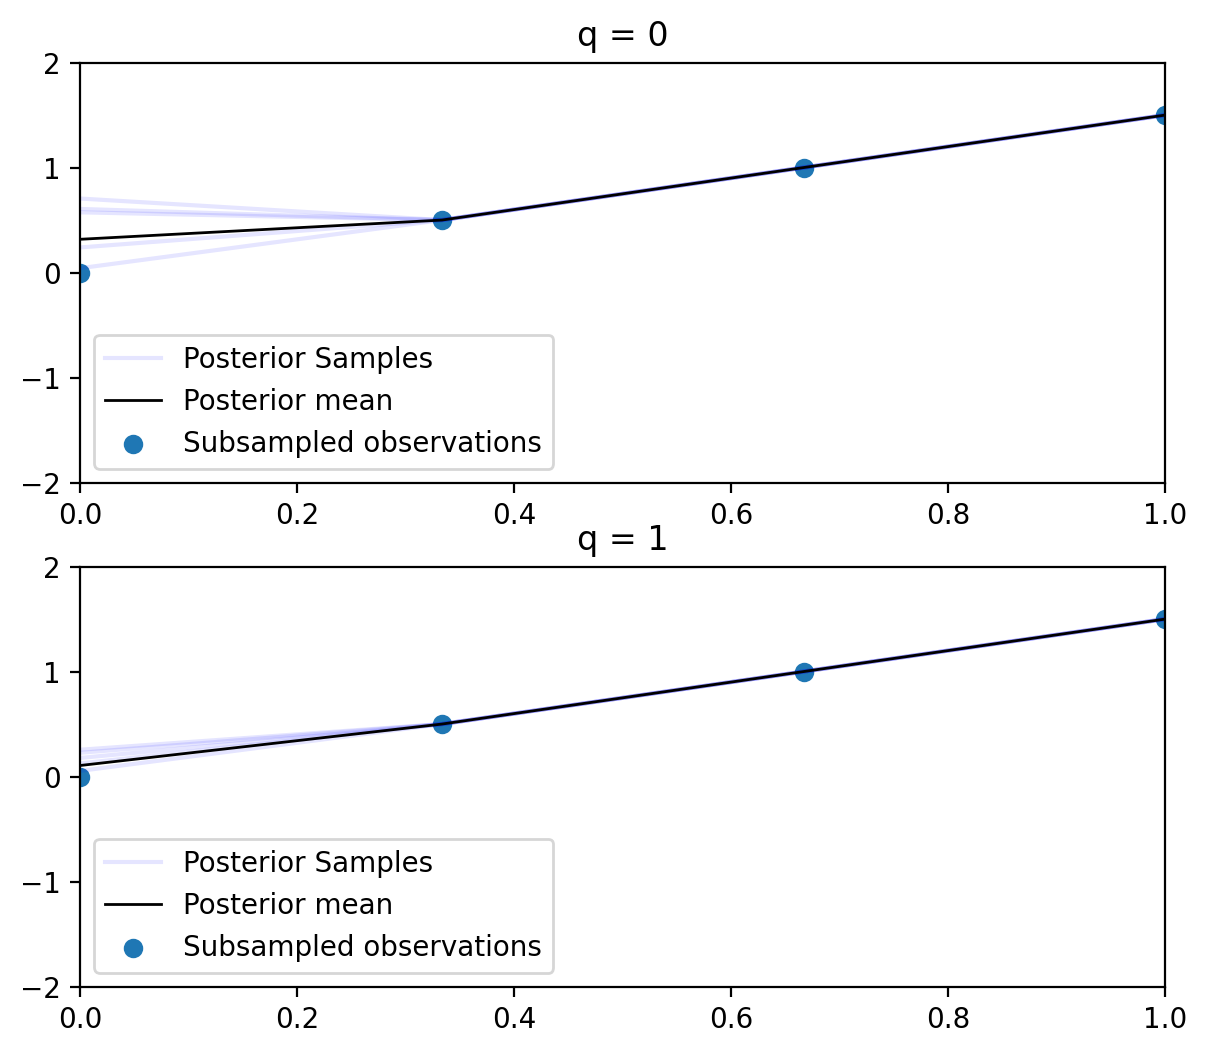

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 4

times = jnp.linspace(0, 1, timesteps, endpoint=True)
y_positions = jnp.array([0.0, 0.5, 1.0, 1.5, 2.0])[:timesteps]

mask = jnp.ones(timesteps).astype(bool)
mask = mask.at[0].set(True)

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(0)
    delta = 1 / (timesteps - 1)

    def obs(state, time, step):
        return state[:1] - y_positions[step]

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-jnp.eye(state) * 10,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([1] + [1.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="iwp",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0,
        n_samples=5,
    )

    for i in range(1, jnp.size(samples_, axis=1)):
        ax.plot(
            times,
            samples_[:, i, 0],
            color="blue",
            alpha=0.1,
        )
    ax.plot(
        times,
        samples_[:, 0, 0],
        label="Posterior Samples",
        color="blue",
        alpha=0.1,
    )
    ax.plot(times, means[:, 0], label="Posterior mean", color="k", linewidth=1)
    ax.scatter(
        times[mask],
        y_positions[mask],
        label="Subsampled observations",
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    ax.legend()


qs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9][:2]
width = 1
height = int(jnp.ceil(len(qs) / width))
fig, ax = plt.subplots(height, width, figsize=(7 * width, 3 * height), dpi=200)
for q, ax in zip(qs, ax.flatten()):
    print(f"Running q = {q}")
    ax.set_title(f"q = {q}")
    fit_trajectory_samples(q, ax)

# Showign interpolation

Running q = 0
SDE_coef
[[0.]]
(1000, 1)
Running q = 1
SDE_coef
[[0. 1.]
 [0. 0.]]
(1000, 2)
Running q = 2
SDE_coef
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
(1000, 3)


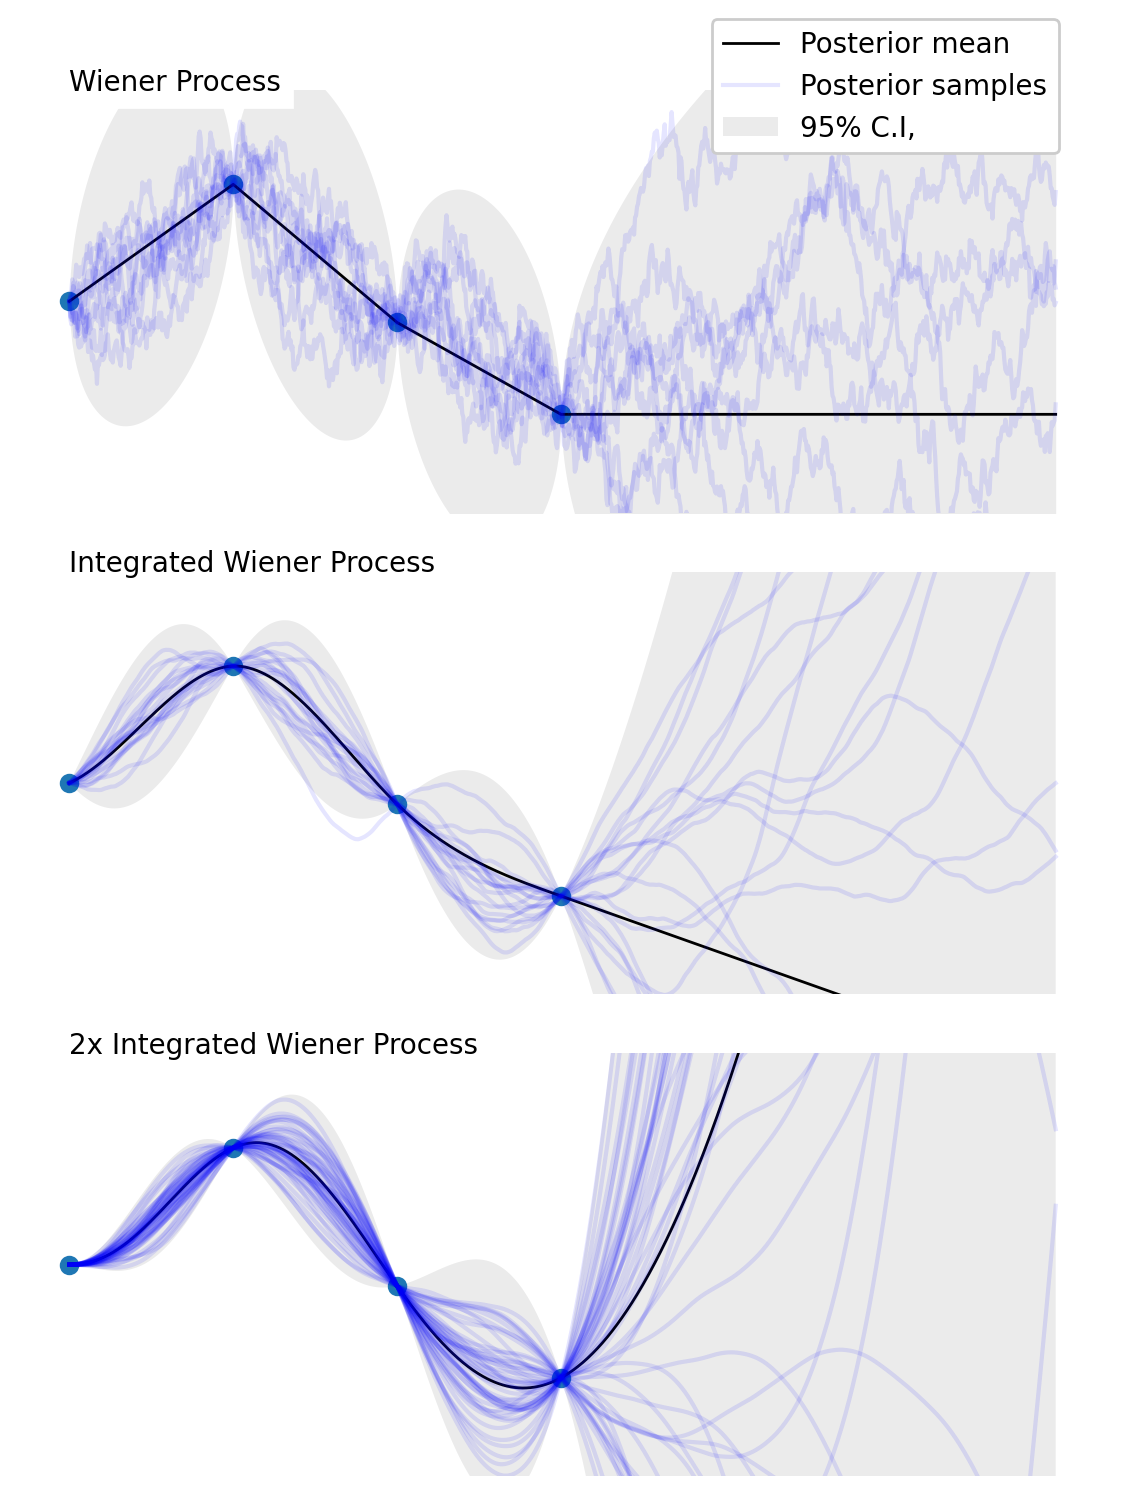

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000

times = jnp.linspace(0, 1, timesteps, endpoint=True)
y_positions = jnp.sin(times * 10)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

mask = jnp.zeros(timesteps).astype(bool)
# mask = mask.at[1].set(True)
mask = mask.at[:: (timesteps // 6)].set(True)
mask = mask.at[0].set(True)
mask = mask.at[-10:].set(False)
mask = mask.at[-1].set(True)
mask = mask.at[-timesteps // 2 :].set(False)

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(y_positions[0])
    delta = 1 / (timesteps - 1)

    def obs(state, time, step):
        return state[:1] - y_positions[step]

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [1.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="iwp",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 20, 50][q],
    )
    print(means.shape)

    ax.plot(times, means[:, 0], label="Posterior mean", color="k", linewidth=1)
    for i in range(1, jnp.size(samples_, axis=1)):
        ax.plot(
            times,
            samples_[:, i, 0],
            color="blue",
            alpha=0.1,
        )
    ax.plot(
        times,
        samples_[:, 0, 0],
        label="Posterior samples",
        color="blue",
        alpha=0.1,
    )
    ax.fill_between(
        times,
        -2.96 * stds[:, 0] + means[:, 0],
        2.96 * stds[:, 0] + means[:, 0],
        label="95% C.I,",
        color="k",
        linewidth=0,
        alpha=0.08,
    )
    ax.scatter(
        times[mask],
        y_positions[mask],
        # label="Subsampled observations",
    )

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-1.8, 1.8)

    ax.set_axis_off()


qs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9][:3]
width = 1
height = int(jnp.ceil(len(qs) / width))
fig, axs = plt.subplots(height, width, figsize=(7 * width, 3 * height), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)
names = ["Wiener Process", "Integrated Wiener Process", "2x Integrated Wiener Process"]
for q, ax, name in zip(qs, axs.flatten(), names):
    print(f"Running q = {q}")
    ax.text(0.0, 1.8, f"{name}", backgroundcolor="white", fontsize=10)
    fit_trajectory_samples(q, ax)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

# fig.savefig(
#     "../markdown/latex/images/conditioned_iwps.png",
#     dpi=300,
#     transparent=True,
#     bbox_inches="tight",
#     pad_inches=0,
# )

# Showing OU

Running q = 0
(1000, 1)
Running q = 1
(1000, 2)
Running q = 2
(1000, 3)


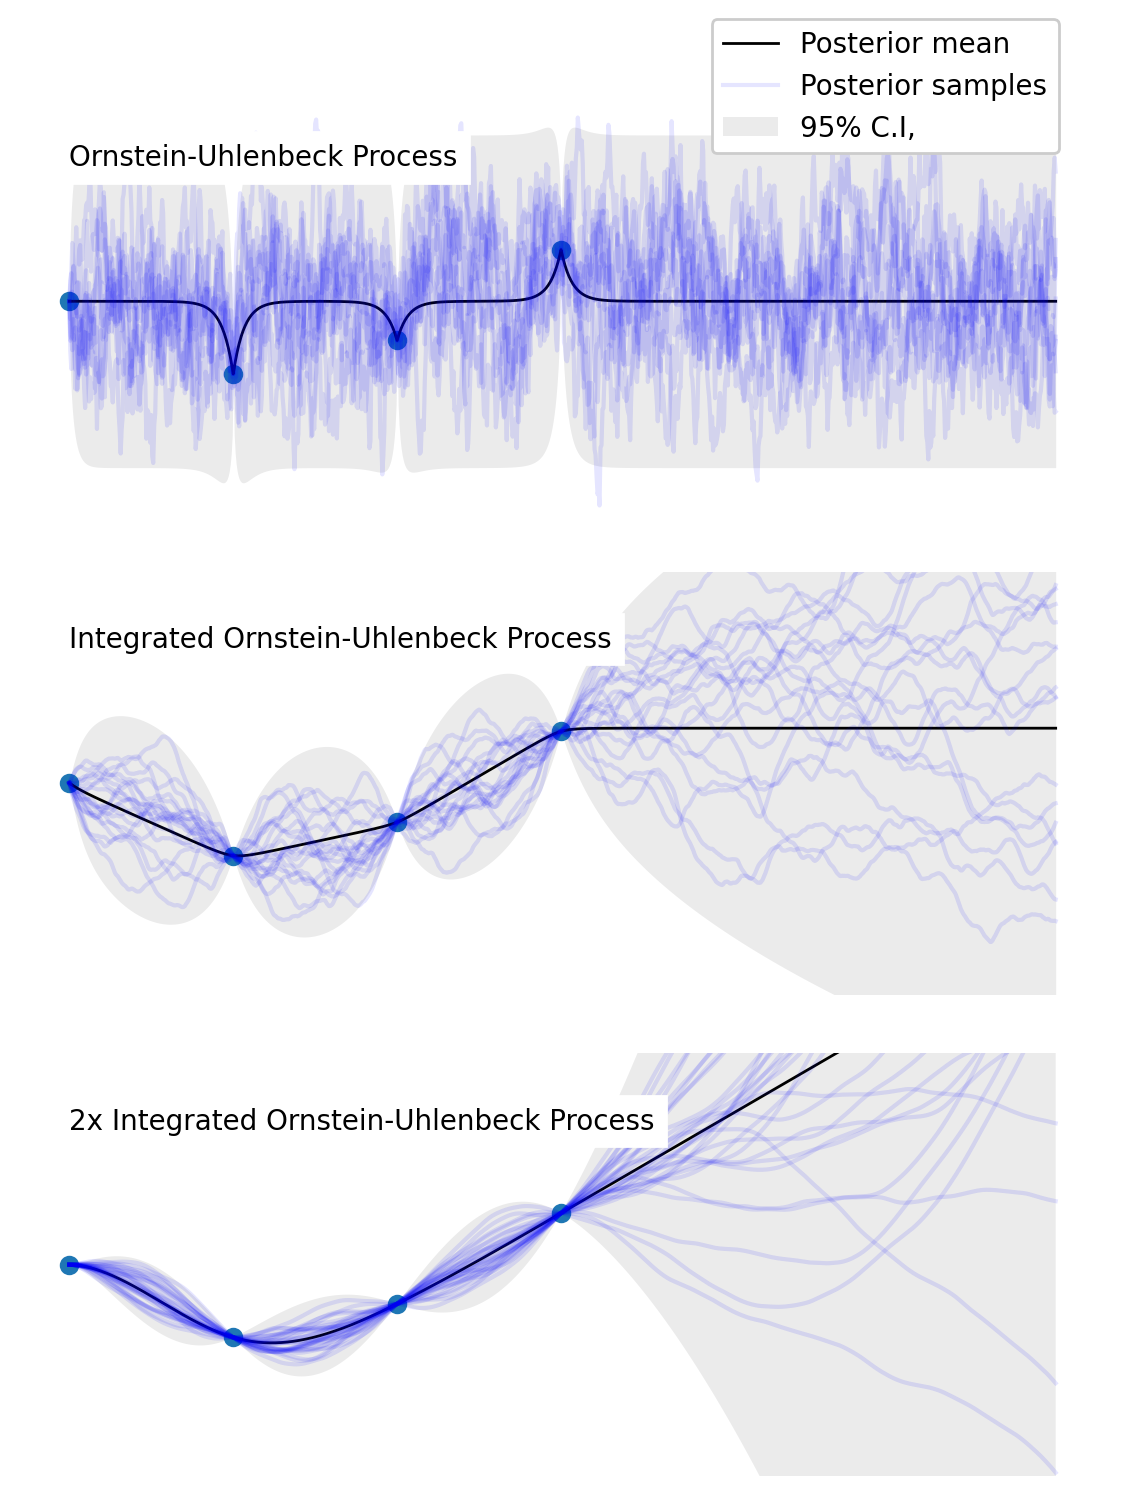

In [37]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000

end_time = 3
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
y_positions = jnp.sin(times * 10)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

mask = jnp.zeros(timesteps).astype(bool)
# mask = mask.at[1].set(True)
mask = mask.at[:: (timesteps // 6)].set(True)
mask = mask.at[0].set(True)
mask = mask.at[-10:].set(False)
mask = mask.at[-1].set(True)
mask = mask.at[-timesteps // 2 :].set(False)

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(y_positions[0])
    delta = end_time / (timesteps - 1)

    def obs(state, time, step):
        return state[:1] - y_positions[step]

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-30 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [1.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="heat",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 20, 30][q],
    )
    print(means.shape)

    ax.plot(times, means[:, 0], label="Posterior mean", color="k", linewidth=1)
    for i in range(1, jnp.size(samples_, axis=1)):
        ax.plot(
            times,
            samples_[:, i, 0],
            color="blue",
            alpha=0.1,
        )
    ax.plot(
        times,
        samples_[:, 0, 0],
        label="Posterior samples",
        color="blue",
        alpha=0.1,
    )
    ax.fill_between(
        times,
        -2.96 * stds[:, 0] + means[:, 0],
        2.96 * stds[:, 0] + means[:, 0],
        label="95% C.I,",
        color="k",
        linewidth=0,
        alpha=0.08,
    )
    ax.scatter(
        times[mask],
        y_positions[mask],
        # label="Subsampled observations",
    )

    # ax.set_xlim(-0.05, 1.05)
    # ax.set_ylim(-1.8, 1.8)
    ax.set_ylim(-2.8, 2.8)

    ax.set_axis_off()


qs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9][:3]
width = 1
height = int(jnp.ceil(len(qs) / width))
fig, axs = plt.subplots(height, width, figsize=(7 * width, 3 * height), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)
names = [
    "Ornstein-Uhlenbeck Process",
    "Integrated Ornstein-Uhlenbeck Process",
    "2x Integrated Ornstein-Uhlenbeck Process",
]
for q, ax, name in zip(qs, axs.flatten(), names):
    print(f"Running q = {q}")
    ax.text(0.0, 1.8, f"{name}", backgroundcolor="white", fontsize=10)
    fit_trajectory_samples(q, ax)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

# fig.savefig(
#     "../markdown/latex/images/conditioned_ous.png",
#     dpi=300,
#     transparent=True,
#     bbox_inches="tight",
#     pad_inches=0,
# )

# Showing Wave Prior

Running q = 1
SDE_coef
[[   0.    1.]
 [-500.    0.]]
(1000, 2)
Running q = 2
SDE_coef
[[   0.    1.    0.]
 [   0.    0.    1.]
 [   0. -500.    0.]]
(1000, 3)
Running q = 3
SDE_coef
[[   0.    1.    0.    0.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]
 [   0.    0. -500.    0.]]
(1000, 4)


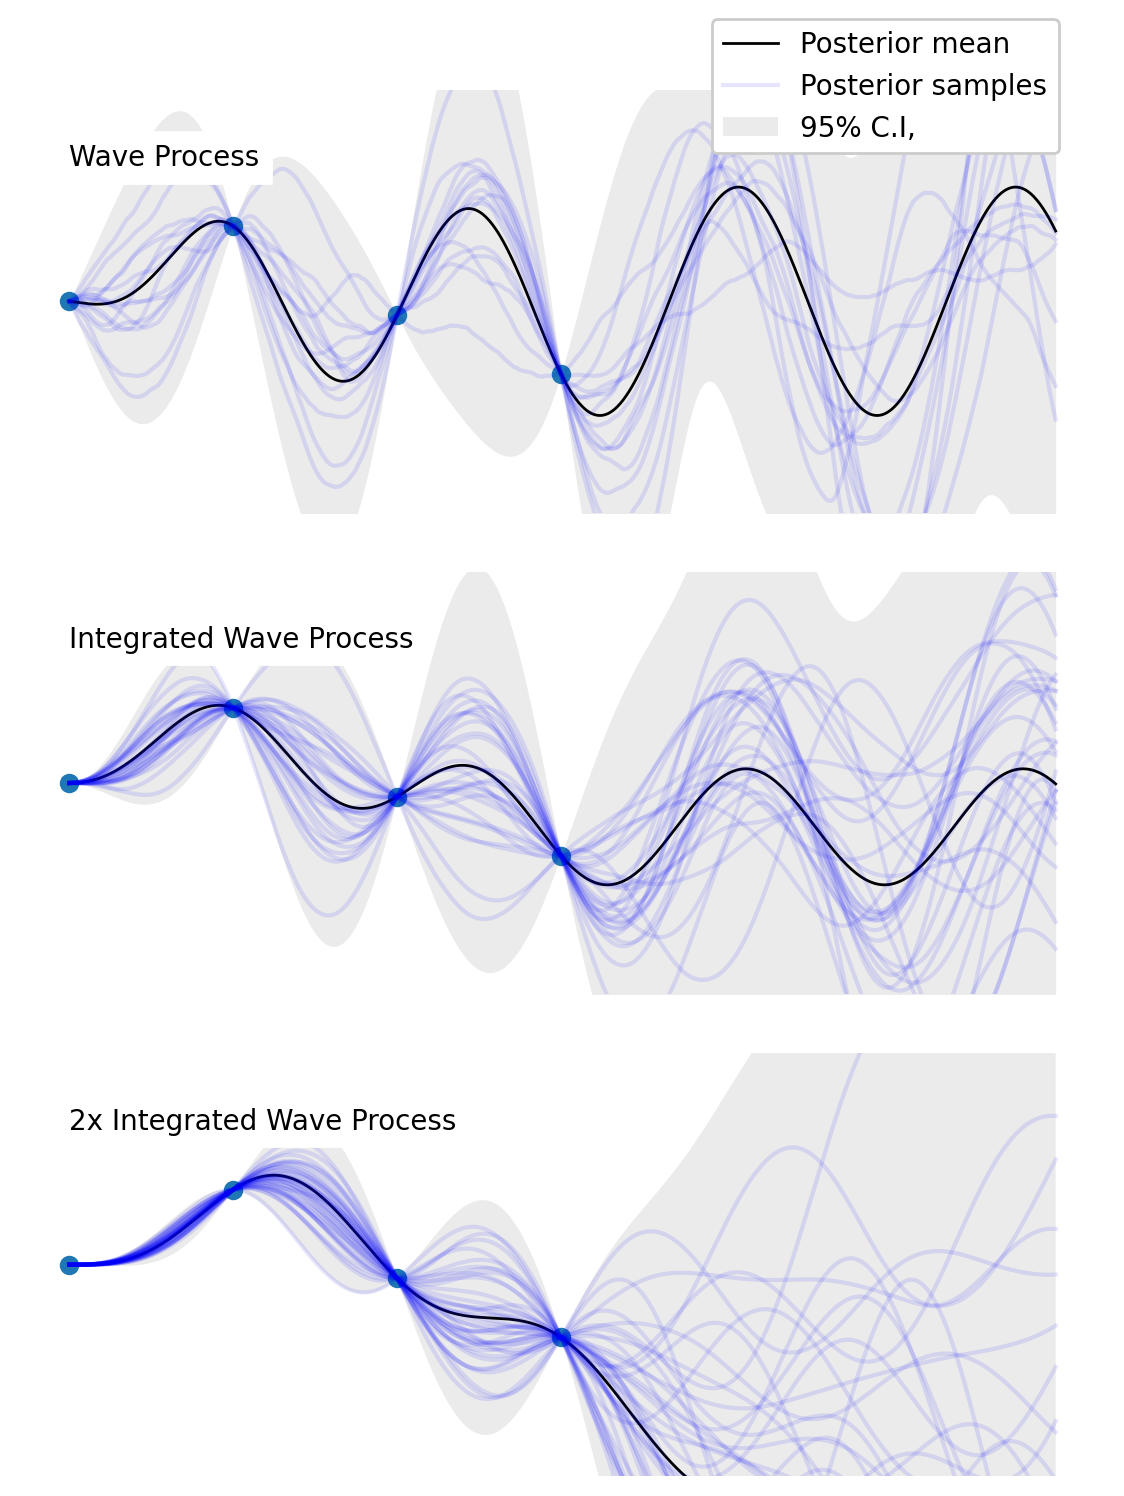

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000

times = jnp.linspace(0, 1, timesteps, endpoint=True)
y_positions = jnp.sin(times * 10)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

mask = jnp.zeros(timesteps).astype(bool)
# mask = mask.at[1].set(True)
mask = mask.at[:: (timesteps // 6)].set(True)
mask = mask.at[0].set(True)
mask = mask.at[-10:].set(False)
mask = mask.at[-1].set(True)
mask = mask.at[-timesteps // 2 :].set(False)

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(y_positions[0])
    delta = 1 / (timesteps - 1)

    def obs(state, time, step):
        return state[:1] - y_positions[step]

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-500 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [1.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="wave",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[0, 15, 30, 40][q],
    )
    print(means.shape)

    ax.plot(times, means[:, 0], label="Posterior mean", color="k", linewidth=1)
    for i in range(1, jnp.size(samples_, axis=1)):
        ax.plot(
            times,
            samples_[:, i, 0],
            color="blue",
            alpha=0.1,
        )
    ax.plot(
        times,
        samples_[:, 0, 0],
        label="Posterior samples",
        color="blue",
        alpha=0.1,
    )
    ax.fill_between(
        times,
        -2.96 * stds[:, 0] + means[:, 0],
        2.96 * stds[:, 0] + means[:, 0],
        label="95% C.I,",
        color="k",
        linewidth=0,
        alpha=0.08,
    )
    ax.scatter(
        times[mask],
        y_positions[mask],
        # label="Subsampled observations",
    )

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-2.8, 2.8)
    # ax.set_ylim(-1.8, 1.8)

    ax.set_axis_off()


qs = [1, 2, 3, 4, 5, 6, 7, 8, 9][:3]
width = 1
height = int(jnp.ceil(len(qs) / width))
fig, axs = plt.subplots(height, width, figsize=(7 * width, 3 * height), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)
names = [
    "Wave Process",
    "Integrated Wave Process",
    "2x Integrated Wave Process",
]
for q, ax, name in zip(qs, axs.flatten(), names):
    print(f"Running q = {q}")
    ax.text(0.0, 1.8, f"{name}", backgroundcolor="white", fontsize=10)
    fit_trajectory_samples(q, ax)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

# fig.savefig(
#     "../markdown/latex/images/conditioned_waves.png",
#     dpi=300,
#     transparent=True,
#     bbox_inches="tight",
#     pad_inches=0,
# )

In [10]:
jnp.array([[0, 1], [2, 3]])[-1:, -2:-1]

Array([[2]], dtype=int64)

# check if integrated wave makes sense?

Running q = 1
SETTING GAMMA TO ONE!!!
Running q = 2
SETTING GAMMA TO ONE!!!
Running q = 3
SETTING GAMMA TO ONE!!!


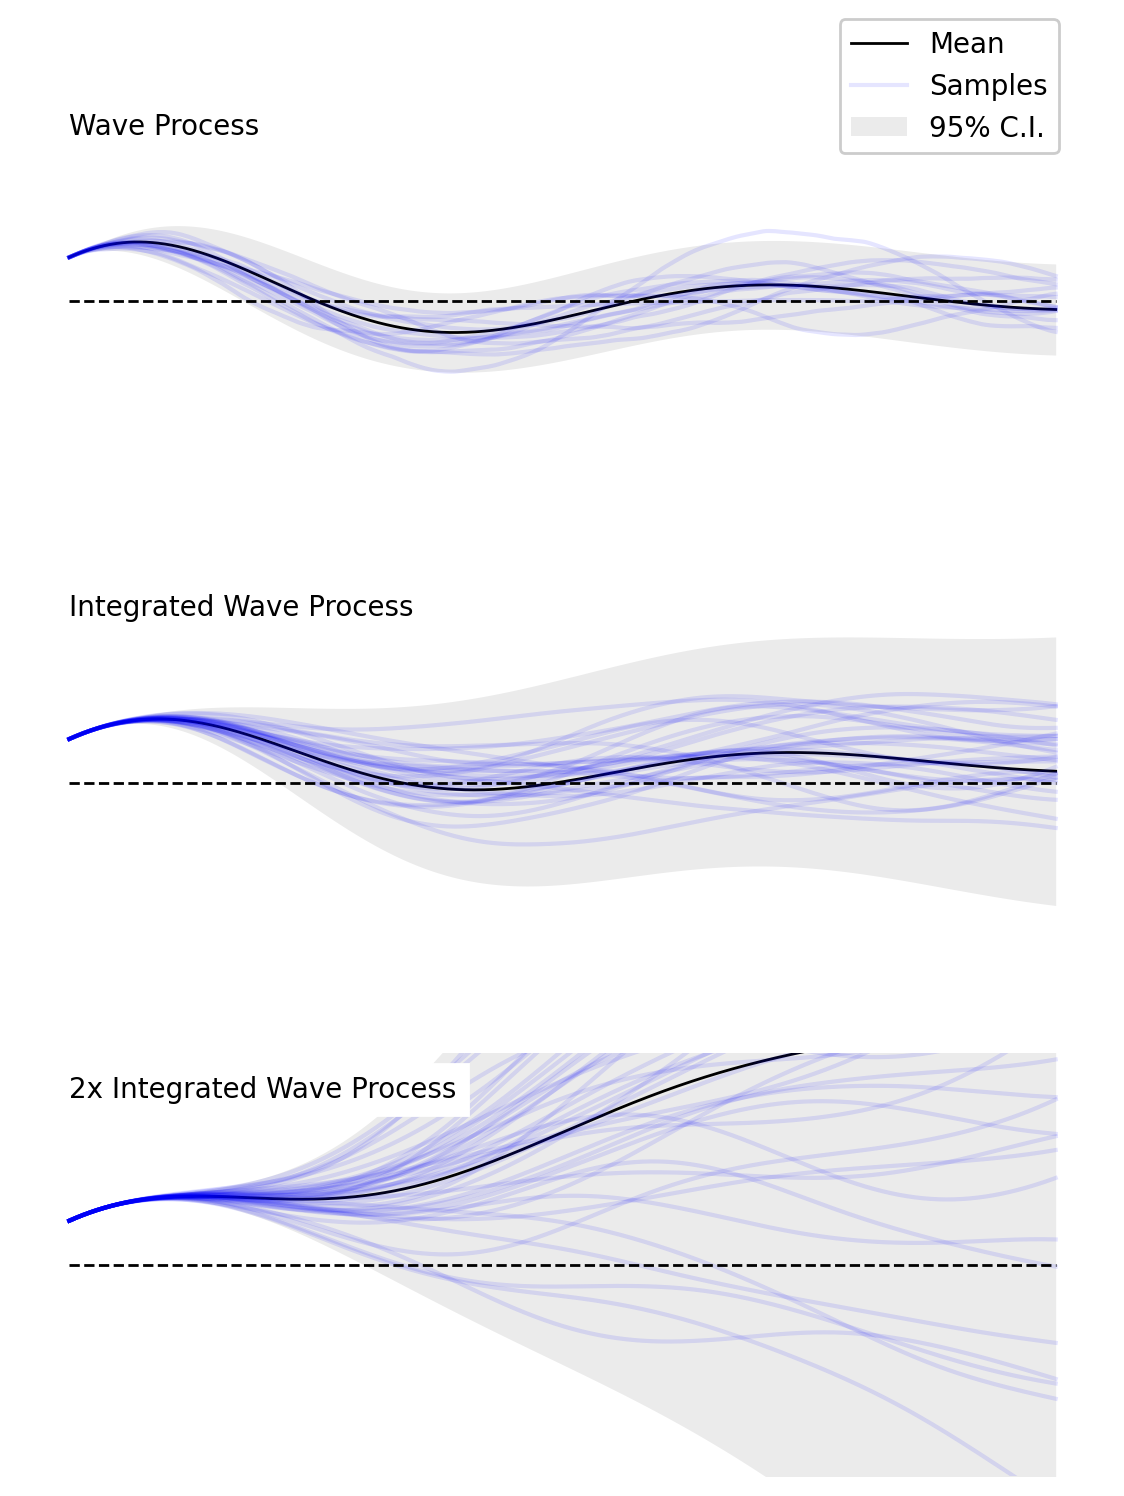

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000

end_time = 10
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
y_positions = jnp.sin(times * 10)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

mask = jnp.zeros(timesteps).astype(bool)
# mask = mask.at[0].set(True)

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 1
    damp = 0.4
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1)
    initial_mean = initial_mean.at[1].set(0)
    initial_mean = initial_mean.at[2].set(-1)
    initial_mean = initial_mean.at[3].set(0)
    initial_mean = initial_mean.at[4].set(1)
    delta = end_time / (timesteps - 1)

    def obs(state, time, step):
        return state[:1] - y_positions[step]

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-jnp.array([1, damp]),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [0.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="two",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 15, 30, 40, 40][q],
    )

    # ax.plot(times, jnp.cos(times), label="Cos", color="k", linewidth=1)
    ax.plot(times, means[:, 0], label="Mean", color="k", linewidth=1)
    for i in range(1, jnp.size(samples_, axis=1)):
        ax.plot(
            times,
            samples_[:, i, 0],
            color="blue",
            alpha=0.1,
        )
    ax.plot(
        times,
        samples_[:, 0, 0],
        label="Samples",
        color="blue",
        alpha=0.1,
    )
    ax.hlines(0, 0, 10, color="k", linestyle="--", linewidth=1)
    ax.fill_between(
        times,
        -2.96 * stds[:, 0] + means[:, 0],
        2.96 * stds[:, 0] + means[:, 0],
        label="95% C.I.",
        color="k",
        linewidth=0,
        alpha=0.08,
    )
    ax.scatter(
        times[mask],
        y_positions[mask],
        # label="Subsampled observations",
    )

    # ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-4.8, 4.8)
    # ax.set_ylim(-1.8, 1.8)

    ax.set_axis_off()


qs = [1, 2, 3, 4, 5, 6, 7, 8, 9][:3]
width = 1
height = int(jnp.ceil(len(qs) / width))
fig, axs = plt.subplots(height, width, figsize=(7 * width, 3 * height), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)
names = [
    "Wave Process",
    "Integrated Wave Process",
    "2x Integrated Wave Process",
    # "3x Integrated Wave Process",
]
for q, ax, name in zip(qs, axs.flatten(), names):
    print(f"Running q = {q}")
    ax.text(0.0, 3.8, f"{name}", backgroundcolor="white", fontsize=10)
    fit_trajectory_samples(q, ax)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

# fig.savefig(
#     "../markdown/latex/images/wave_process.png",
#     dpi=300,
#     transparent=True,
#     bbox_inches="tight",
#     pad_inches=0,
# )

# showing solver for damped wave equation

/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


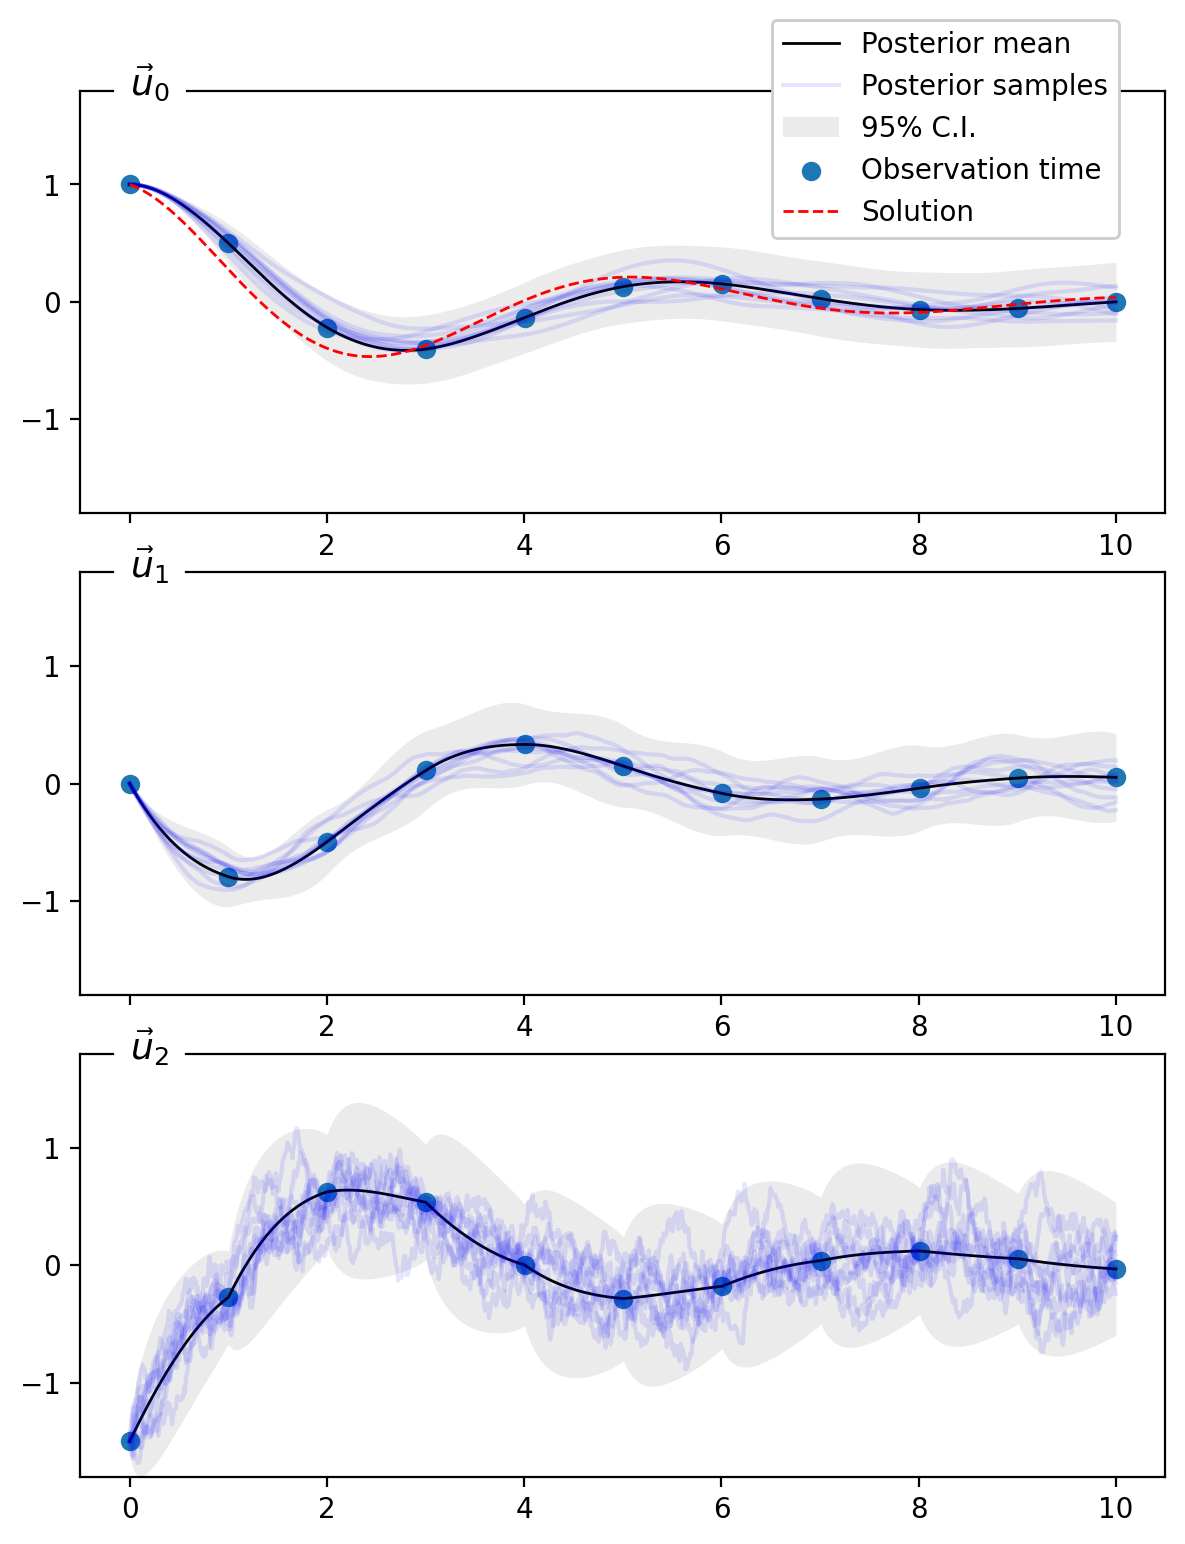

In [81]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000
end_time = 10
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, n_observations, axs):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    k = 1.5
    d = 0.6
    initial_mean = initial_mean.at[0].set(1)
    initial_mean = initial_mean.at[2].set(-k)
    delta = end_time / (timesteps - 1)

    def obs(state, time, step):
        return state[2:3] + k * state[0:1] + d * state[1:2]

    updates = jnp.zeros((timesteps)).astype(bool)
    updates = updates.at[:: (timesteps // n_observations)].set(1)
    updates = updates.at[-1].set(1)

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=0 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [0.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="IWP",
        observation_function=obs,
        update_indicator=updates,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 15, 10, 10, 10][q],
    )
    names = [r"$\vec{u}_0$", r"$\vec{u}_1$", r"$\vec{u}_2$"]
    for q, (ax, name) in enumerate(zip(axs.flatten(), names)):
        ax.plot(times, means[:, q], label="Posterior mean", color="k", linewidth=1)
        for i in range(1, jnp.size(samples_, axis=1)):
            ax.plot(
                times,
                samples_[:, i, q],
                color="blue",
                alpha=0.1,
            )
        ax.plot(
            times,
            samples_[:, 0, q],
            label="Posterior samples",
            color="blue",
            alpha=0.1,
        )
        ax.fill_between(
            times,
            -2.96 * stds[:, q] + means[:, q],
            2.96 * stds[:, q] + means[:, q],
            label="95% C.I.",
            color="k",
            linewidth=0,
            alpha=0.08,
        )
        ax.scatter(
            times[updates],
            means[:, q][updates],
            label="Observation time",
        )

        # ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-1.8, 1.8)

        # ax.set_axis_off()
        ax.text(0.0, 1.75, f"{name}", backgroundcolor="white", fontsize=13)

    # plotting true damped harmonic oscillator solution

    axs[0].plot(
        times,
        (jnp.cos(times * jnp.sqrt(k - (d**2) / 4))) * jnp.exp(-times * (d / 2)),
        label="Solution",
        color="r",
        linestyle="--",
        linewidth=1,
    )


fig, axs = plt.subplots(3, 1, figsize=(7, 3 * 3), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)


fit_trajectory_samples(2, 10, axs)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

fig.savefig(
    "../markdown/latex/images/solving_damped_spring_few_points.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

# spring bigger state

[Array(1., dtype=float64), Array(0., dtype=float64), Array(-1.5, dtype=float64), Array(0.9, dtype=float64), Array(1.71, dtype=float64)]


/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


[Array(1., dtype=float64), Array(0., dtype=float64), Array(-1.5, dtype=float64), Array(0.9, dtype=float64), Array(1.71, dtype=float64)]


/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


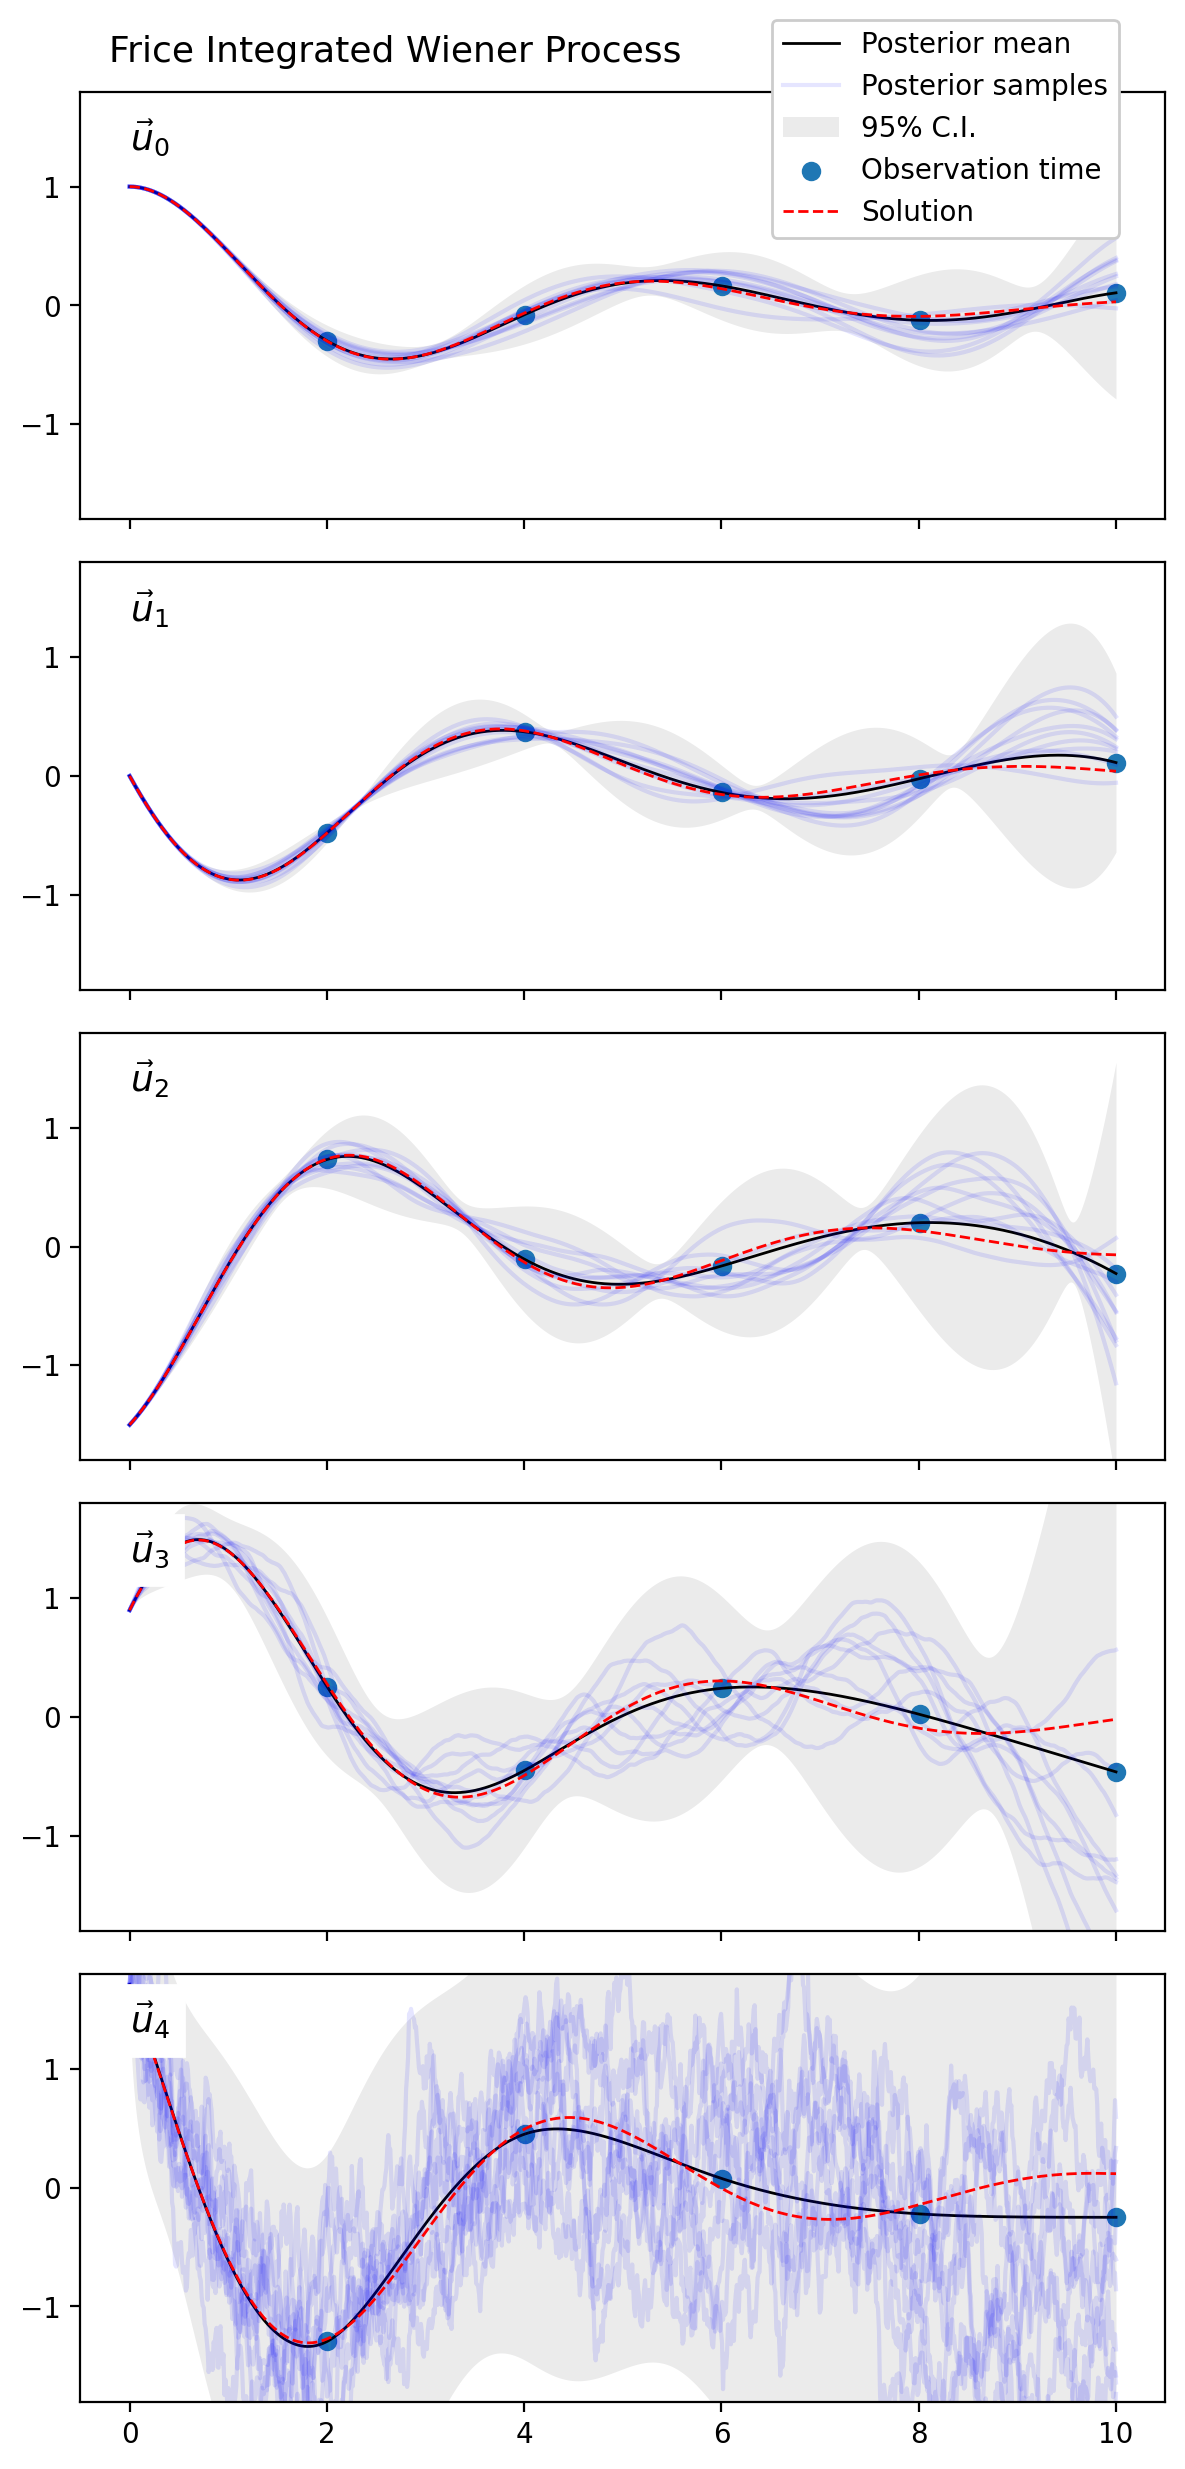

In [116]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000
end_time = 10
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

from probabilistic_numerics import kalman_filter as pn
import probdiffeq.taylor as taylor


def fit_trajectory_samples(q, n_observations, axs):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    k = 1.5
    d = 0.6
    initial_mean = initial_mean.at[0].set(1)
    initial_mean = initial_mean.at[2].set(-k)
    delta = end_time / (timesteps - 1)

    tcoeffs = taylor.odejet_padded_scan(
        lambda y, dy: -k * y - d * dy, (initial_mean[0], initial_mean[1]), num=q - 1
    )
    print(tcoeffs)
    initial_mean = jnp.array(tcoeffs).flatten()

    def obs(state, time, step):
        return state[2:3] + k * state[0:1] + d * state[1:2]

    updates = jnp.zeros((timesteps)).astype(bool)
    updates = updates.at[:: (timesteps // n_observations)].set(1)
    updates = updates.at[0].set(0)
    updates = updates.at[-1].set(1)

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=0 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [0.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="IWP",
        observation_function=obs,
        update_indicator=updates,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 15, 10, 10, 10][q],
    )
    names = [
        r"$\vec{u}_0$",
        r"$\vec{u}_1$",
        r"$\vec{u}_2$",
        r"$\vec{u}_3$",
        r"$\vec{u}_4$",
    ]
    for q, (ax, name) in enumerate(zip(axs.flatten(), names)):
        ax.plot(times, means[:, q], label="Posterior mean", color="k", linewidth=1)
        for i in range(1, jnp.size(samples_, axis=1)):
            ax.plot(
                times,
                samples_[:, i, q],
                color="blue",
                alpha=0.1,
            )
        ax.plot(
            times,
            samples_[:, 0, q],
            label="Posterior samples",
            color="blue",
            alpha=0.1,
        )
        ax.fill_between(
            times,
            -2.96 * stds[:, q] + means[:, q],
            2.96 * stds[:, q] + means[:, q],
            label="95% C.I.",
            color="k",
            linewidth=0,
            alpha=0.08,
        )
        ax.scatter(
            times[updates],
            means[:, q][updates],
            label="Observation time",
        )

        # ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-1.8, 1.8)

        # ax.set_axis_off()
        ax.text(0.0, 1.3, f"{name}", backgroundcolor="white", fontsize=13)

    # plotting true damped harmonic oscillator solution
    return means


q = 4
fig, axs = plt.subplots(2, 1, figsize=(7, 3 * (q + 1)), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)


solution = fit_trajectory_samples(q, 100, axs)

plt.close(fig)


fig, axs = plt.subplots(q + 1, 1, figsize=(7, 3 * (q + 1)), dpi=200, sharex=True)
# less horizontal space
fig.subplots_adjust(hspace=0.1)
_ = fit_trajectory_samples(q, 5, axs)
axs[0].plot(
    times, solution[:, 0], label="Solution", color="r", linestyle="--", linewidth=1
)
axs[1].plot(times, solution[:, 1], color="r", linestyle="--", linewidth=1)
axs[2].plot(times, solution[:, 2], color="r", linestyle="--", linewidth=1)
axs[3].plot(times, solution[:, 3], color="r", linestyle="--", linewidth=1)
axs[4].plot(times, solution[:, 4], color="r", linestyle="--", linewidth=1)
fig.text(
    0.35,
    0.89,
    f"Frice Integrated Wiener Process",
    backgroundcolor="white",
    fontsize=13,
    ha="center",
)
# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

fig.savefig(
    "../markdown/latex/images/solving_damped_spring_big_state.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

[Array(1., dtype=float64), Array(0., dtype=float64), Array(-1.5, dtype=float64), Array(0.9, dtype=float64), Array(1.71, dtype=float64)]
[Array(1., dtype=float64), Array(0., dtype=float64), Array(-1.5, dtype=float64)]


/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


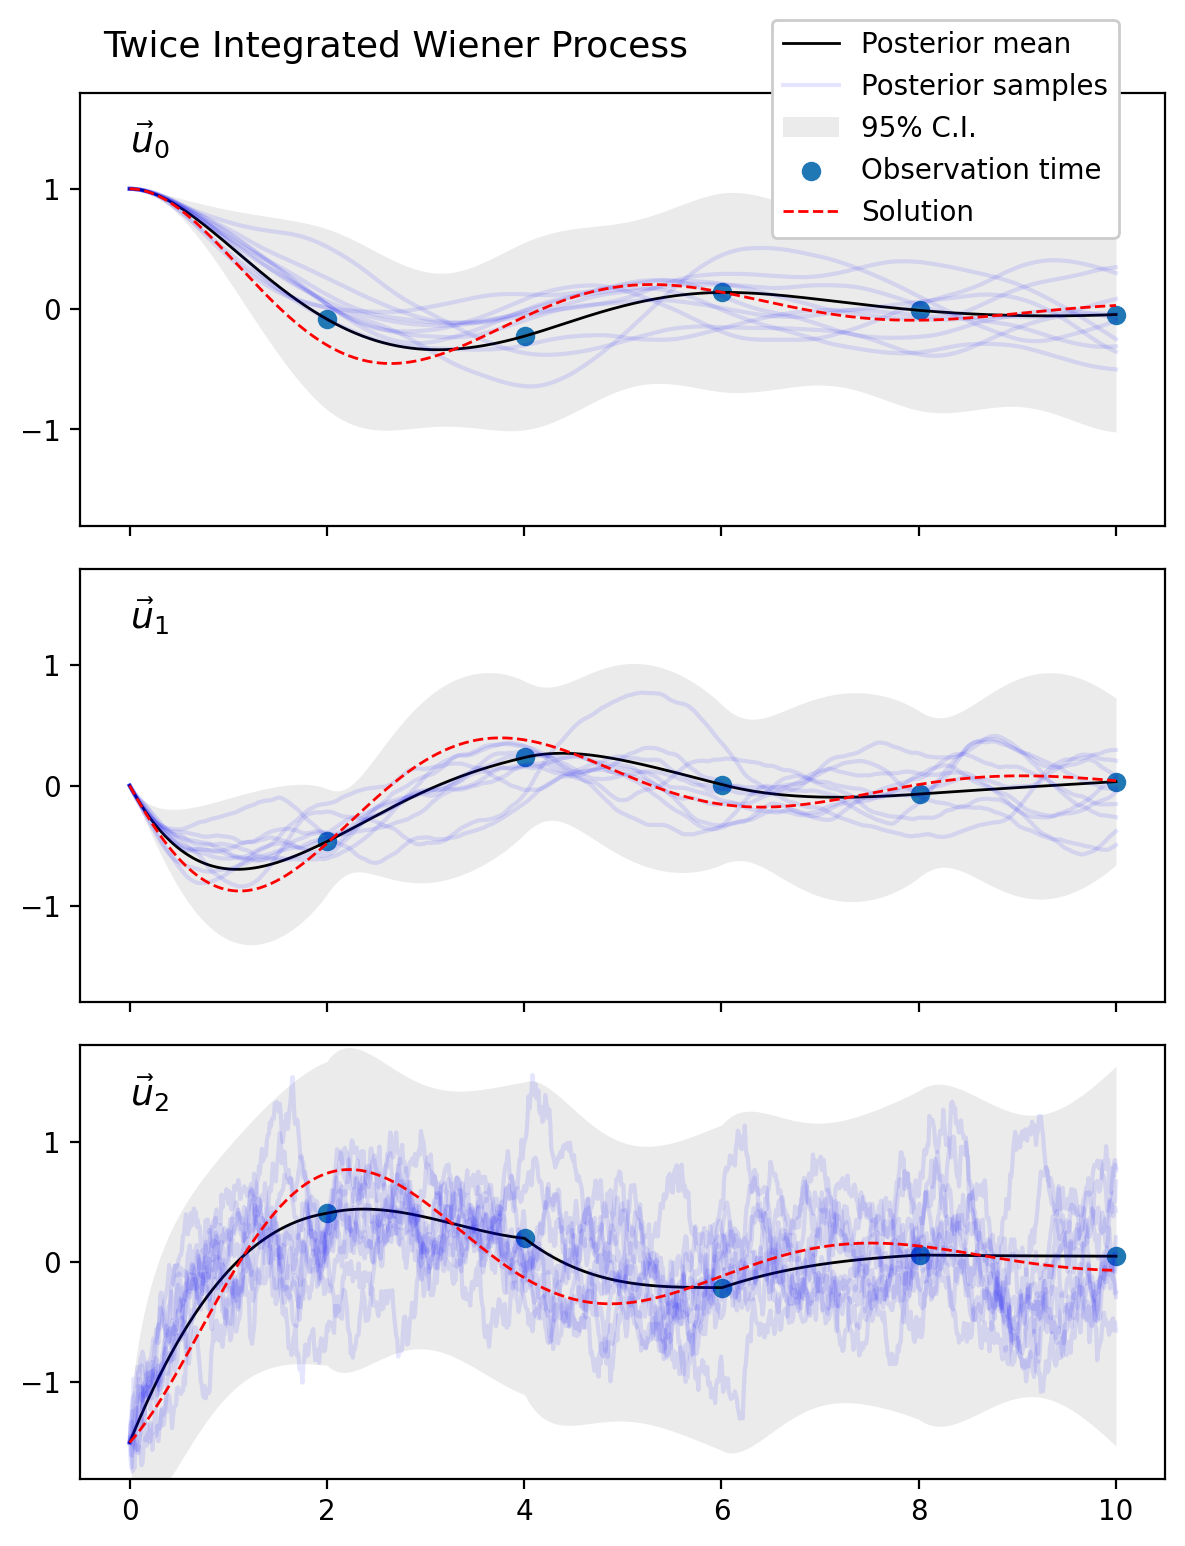

In [117]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000
end_time = 10
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

from probabilistic_numerics import kalman_filter as pn
import probdiffeq.taylor as taylor


def fit_trajectory_samples(q, n_observations, axs):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    k = 1.5
    d = 0.6
    initial_mean = initial_mean.at[0].set(1)
    initial_mean = initial_mean.at[2].set(-k)
    delta = end_time / (timesteps - 1)

    tcoeffs = taylor.odejet_padded_scan(
        lambda y, dy: -k * y - d * dy, (initial_mean[0], initial_mean[1]), num=q - 1
    )
    print(tcoeffs)
    initial_mean = jnp.array(tcoeffs).flatten()

    def obs(state, time, step):
        return state[2:3] + k * state[0:1] + d * state[1:2]

    updates = jnp.zeros((timesteps)).astype(bool)
    updates = updates.at[:: (timesteps // n_observations)].set(1)
    updates = updates.at[0].set(0)
    updates = updates.at[-1].set(1)

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=0 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [0.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="IWP",
        observation_function=obs,
        update_indicator=updates,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 15, 10, 10, 10][q],
    )
    names = [
        r"$\vec{u}_0$",
        r"$\vec{u}_1$",
        r"$\vec{u}_2$",
        r"$\vec{u}_3$",
        r"$\vec{u}_4$",
    ]
    for q, (ax, name) in enumerate(zip(axs.flatten(), names)):
        ax.plot(times, means[:, q], label="Posterior mean", color="k", linewidth=1)
        for i in range(1, jnp.size(samples_, axis=1)):
            ax.plot(
                times,
                samples_[:, i, q],
                color="blue",
                alpha=0.1,
            )
        ax.plot(
            times,
            samples_[:, 0, q],
            label="Posterior samples",
            color="blue",
            alpha=0.1,
        )
        ax.fill_between(
            times,
            -2.96 * stds[:, q] + means[:, q],
            2.96 * stds[:, q] + means[:, q],
            label="95% C.I.",
            color="k",
            linewidth=0,
            alpha=0.08,
        )
        ax.scatter(
            times[updates],
            means[:, q][updates],
            label="Observation time",
        )

        # ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-1.8, 1.8)

        # ax.set_axis_off()
        ax.text(0.0, 1.3, f"{name}", backgroundcolor="white", fontsize=13)

    # plotting true damped harmonic oscillator solution
    return means


fig, axs = plt.subplots(2, 1, figsize=(7, 3 * (q + 1)), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)


solution = fit_trajectory_samples(4, 100, axs)

plt.close(fig)


q = 2
fig, axs = plt.subplots(q + 1, 1, figsize=(7, 3 * (q + 1)), dpi=200, sharex=True)
# less horizontal space
fig.subplots_adjust(hspace=0.1)
_ = fit_trajectory_samples(q, 5, axs)
axs[0].plot(
    times, solution[:, 0], label="Solution", color="r", linestyle="--", linewidth=1
)
axs[1].plot(times, solution[:, 1], color="r", linestyle="--", linewidth=1)
axs[2].plot(times, solution[:, 2], color="r", linestyle="--", linewidth=1)
fig.text(
    0.35,
    0.9,
    f"Twice Integrated Wiener Process",
    backgroundcolor="white",
    fontsize=13,
    ha="center",
)

# legend above first plot
axs[0].legend(
    fancybox=True,
    framealpha=1,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.97, 1.2),
)

fig.savefig(
    "../markdown/latex/images/solving_damped_spring_small_state.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

# Spring incremental solve

/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


SETTING GAMMA TO ONE!!!


/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_78179/3808415399.py:146: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))
/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_78179/3808415399.py:146: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call 

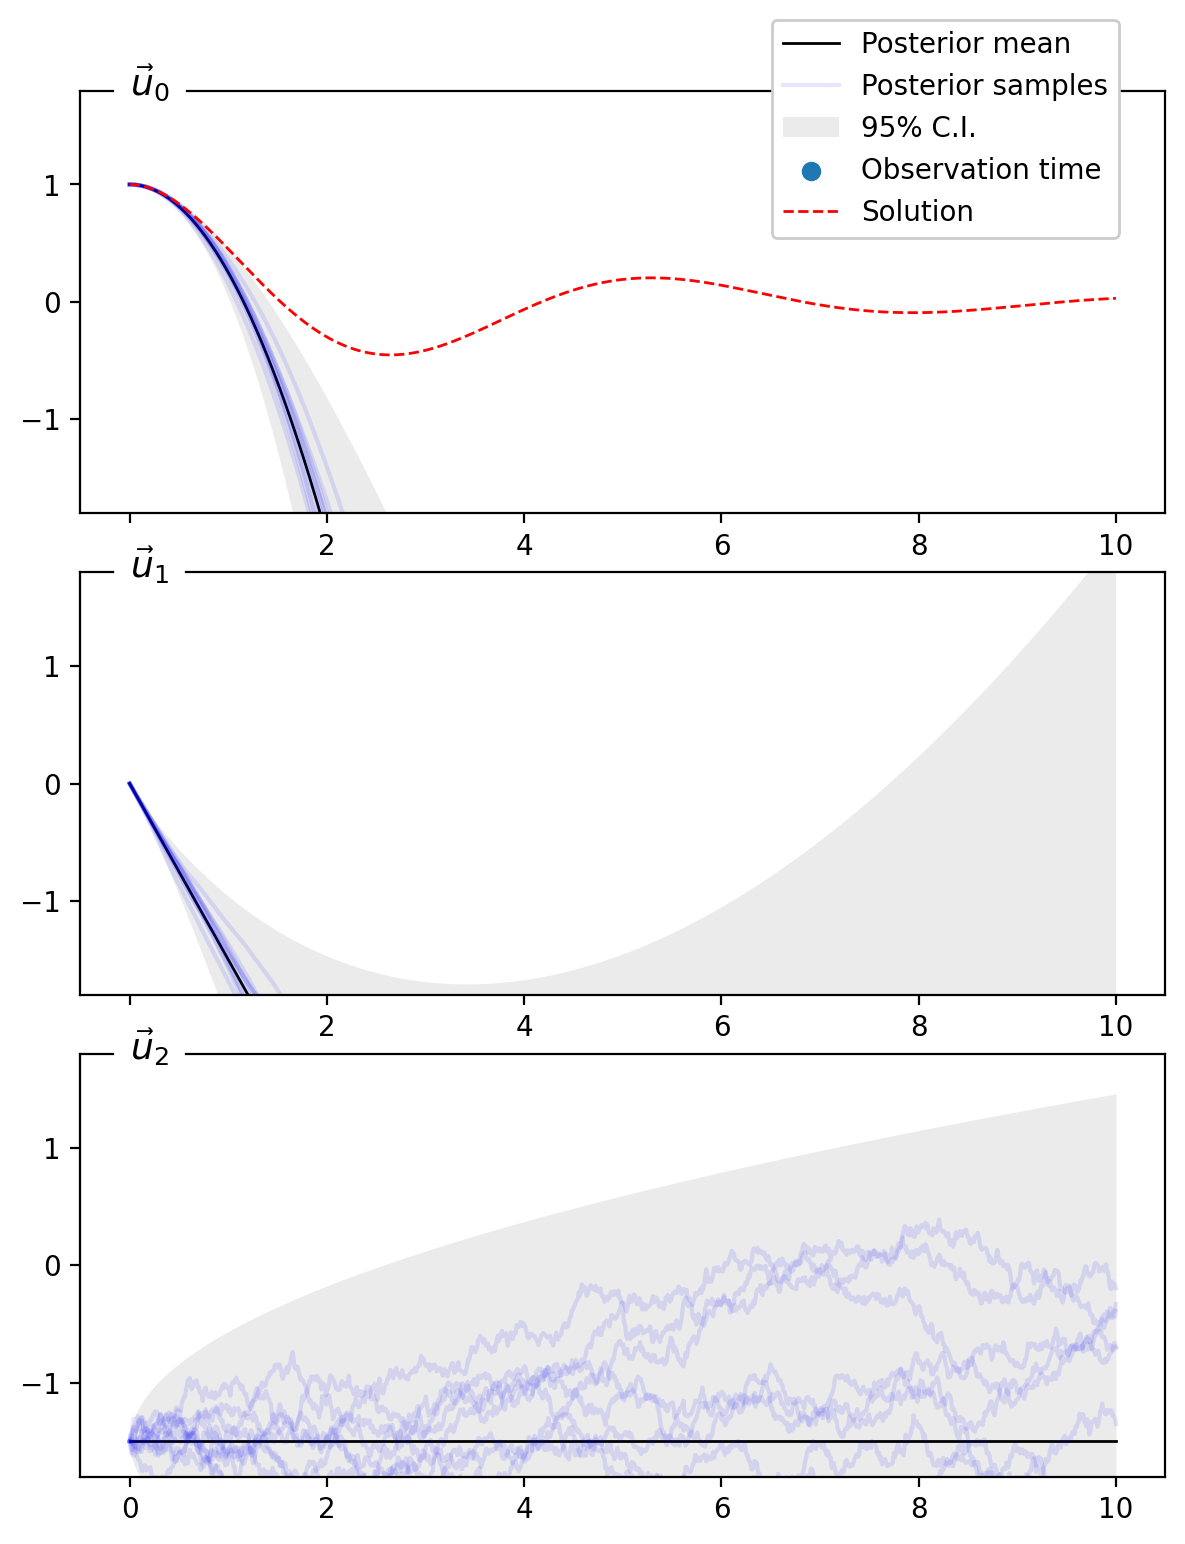

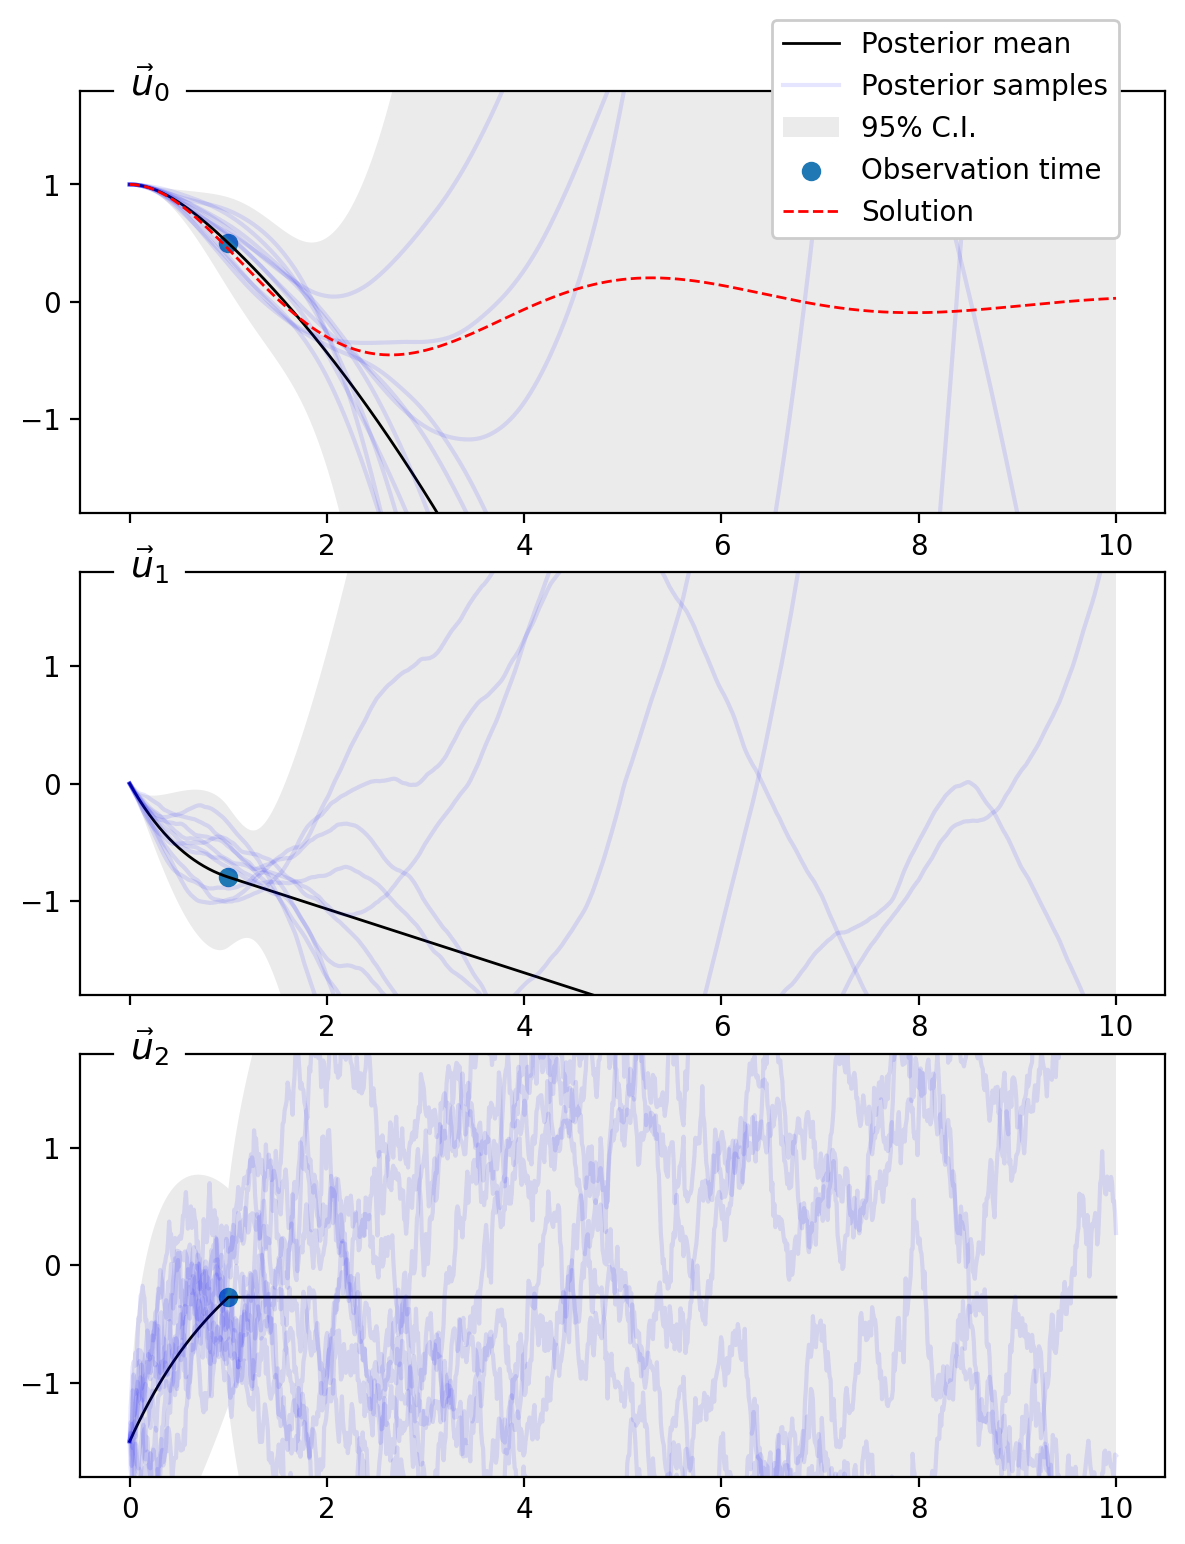

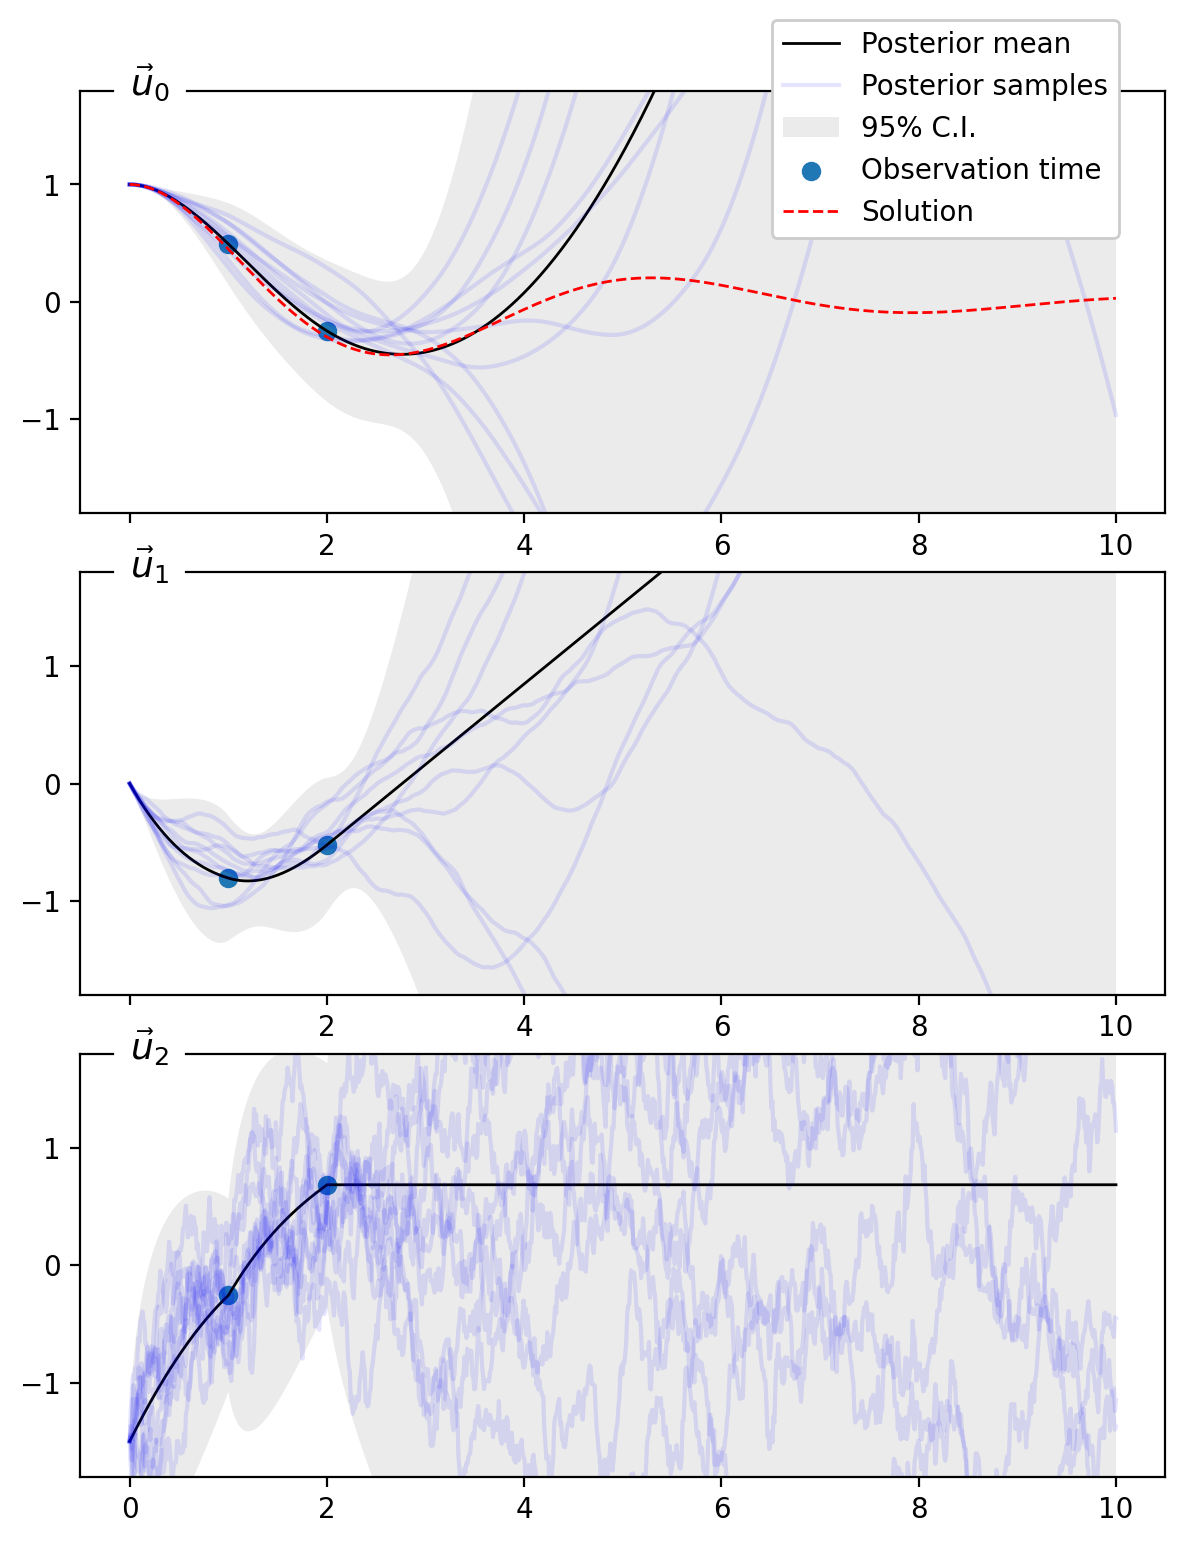

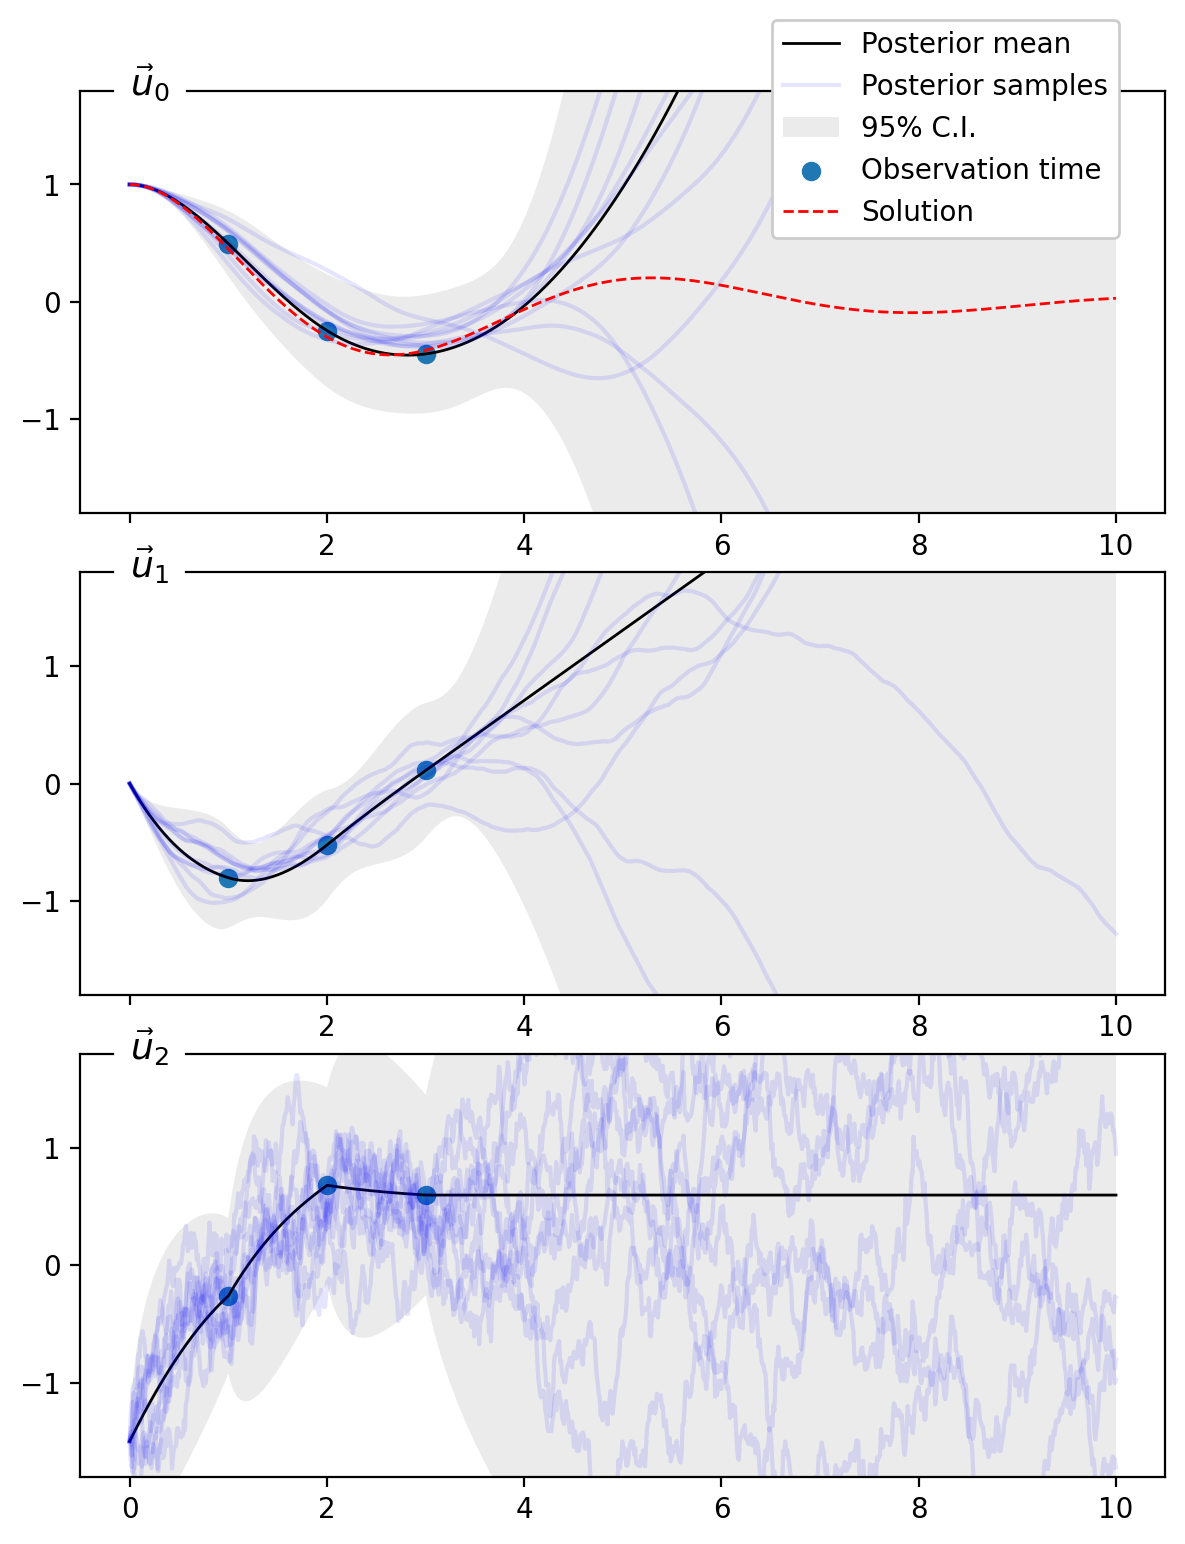

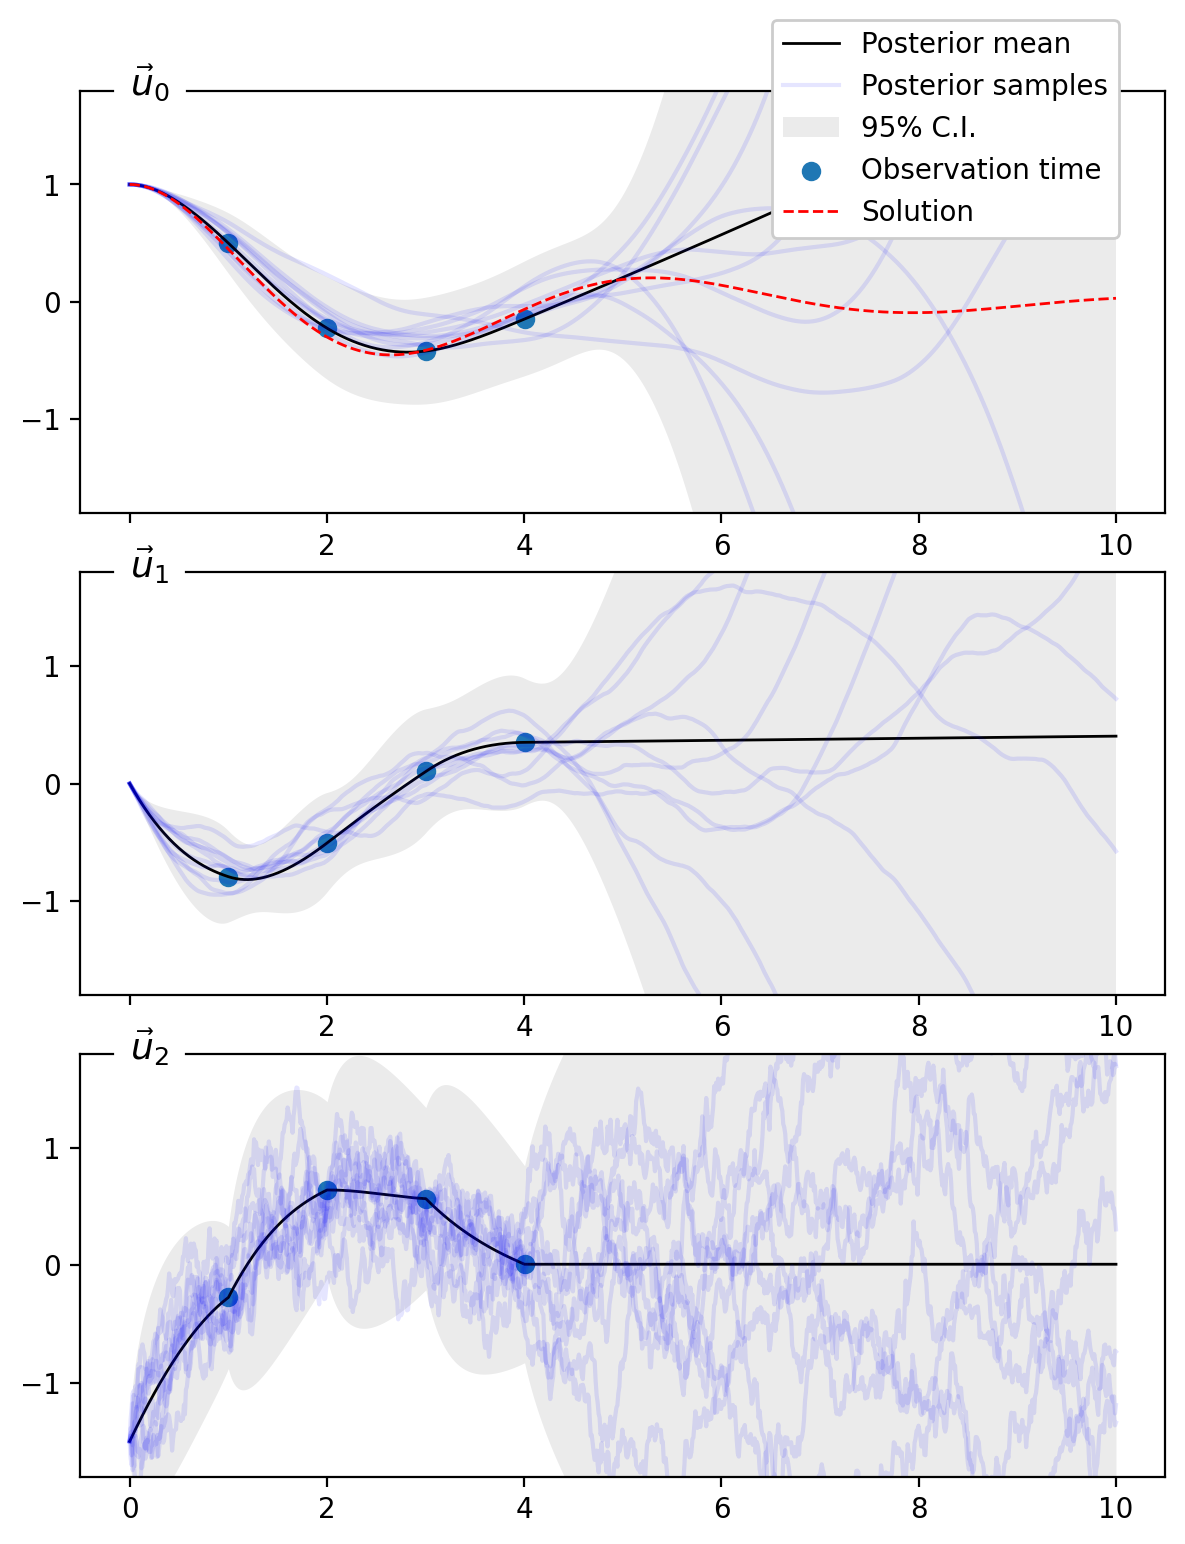

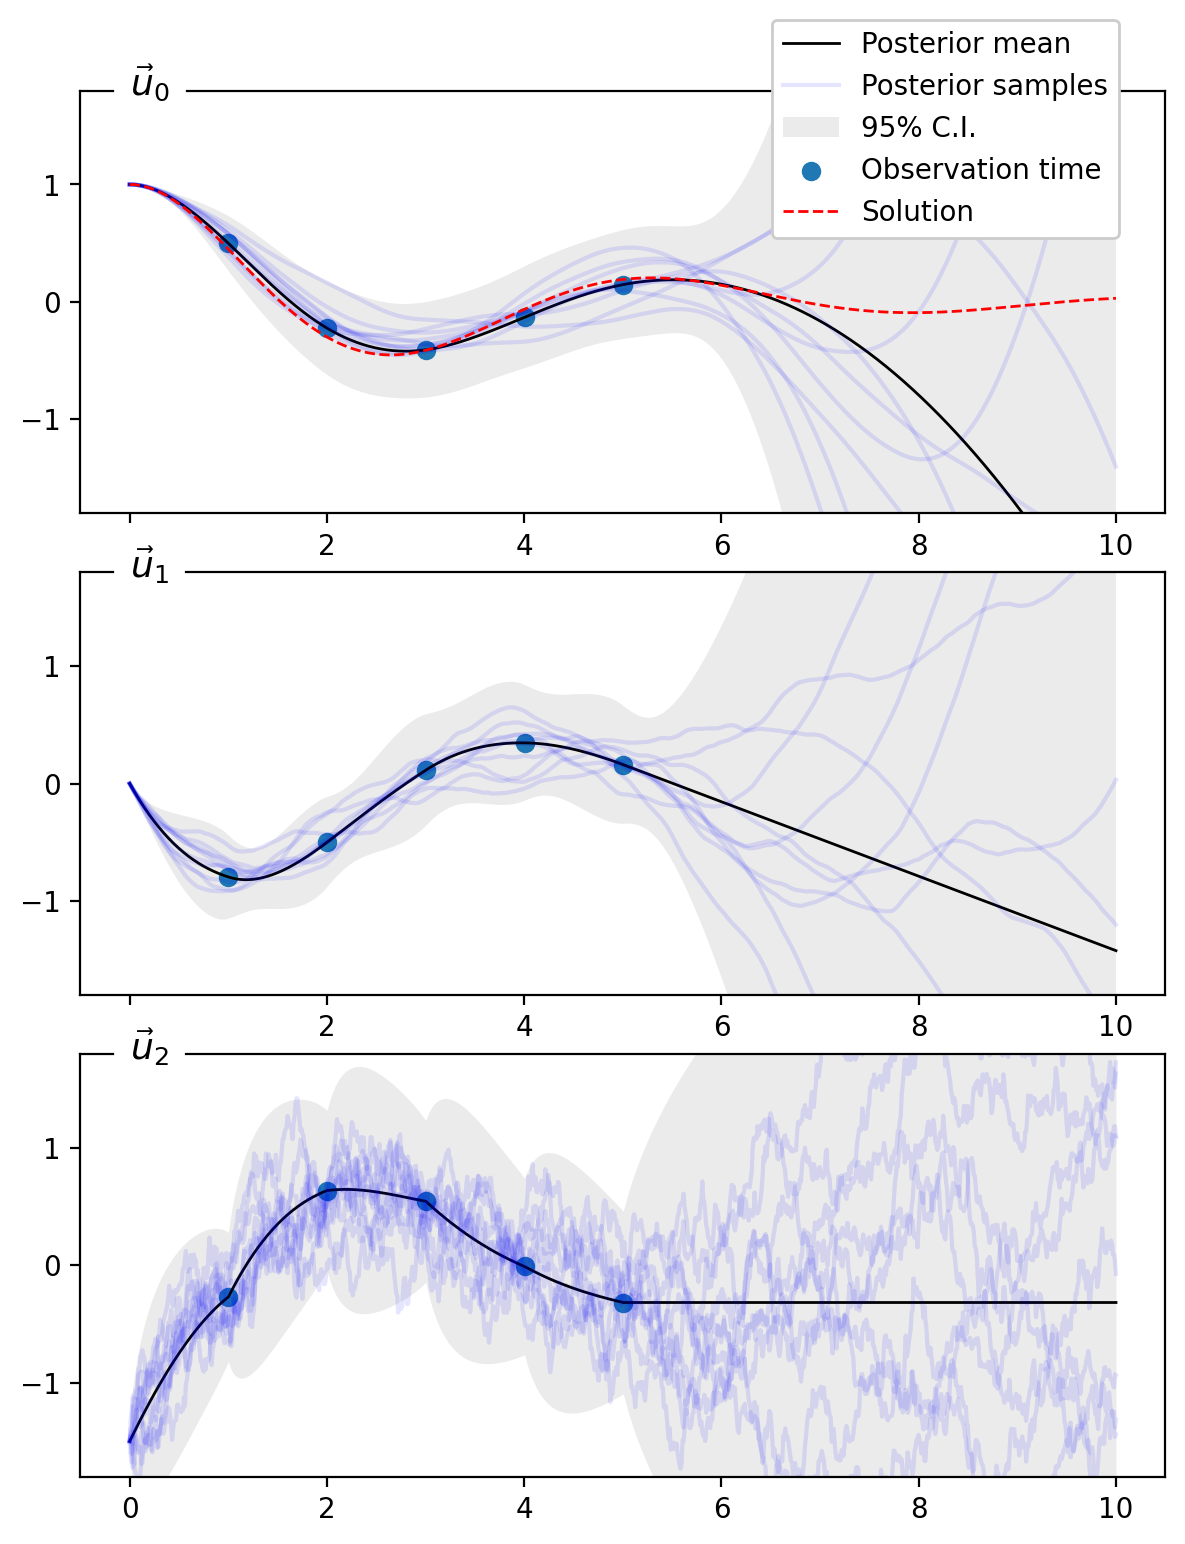

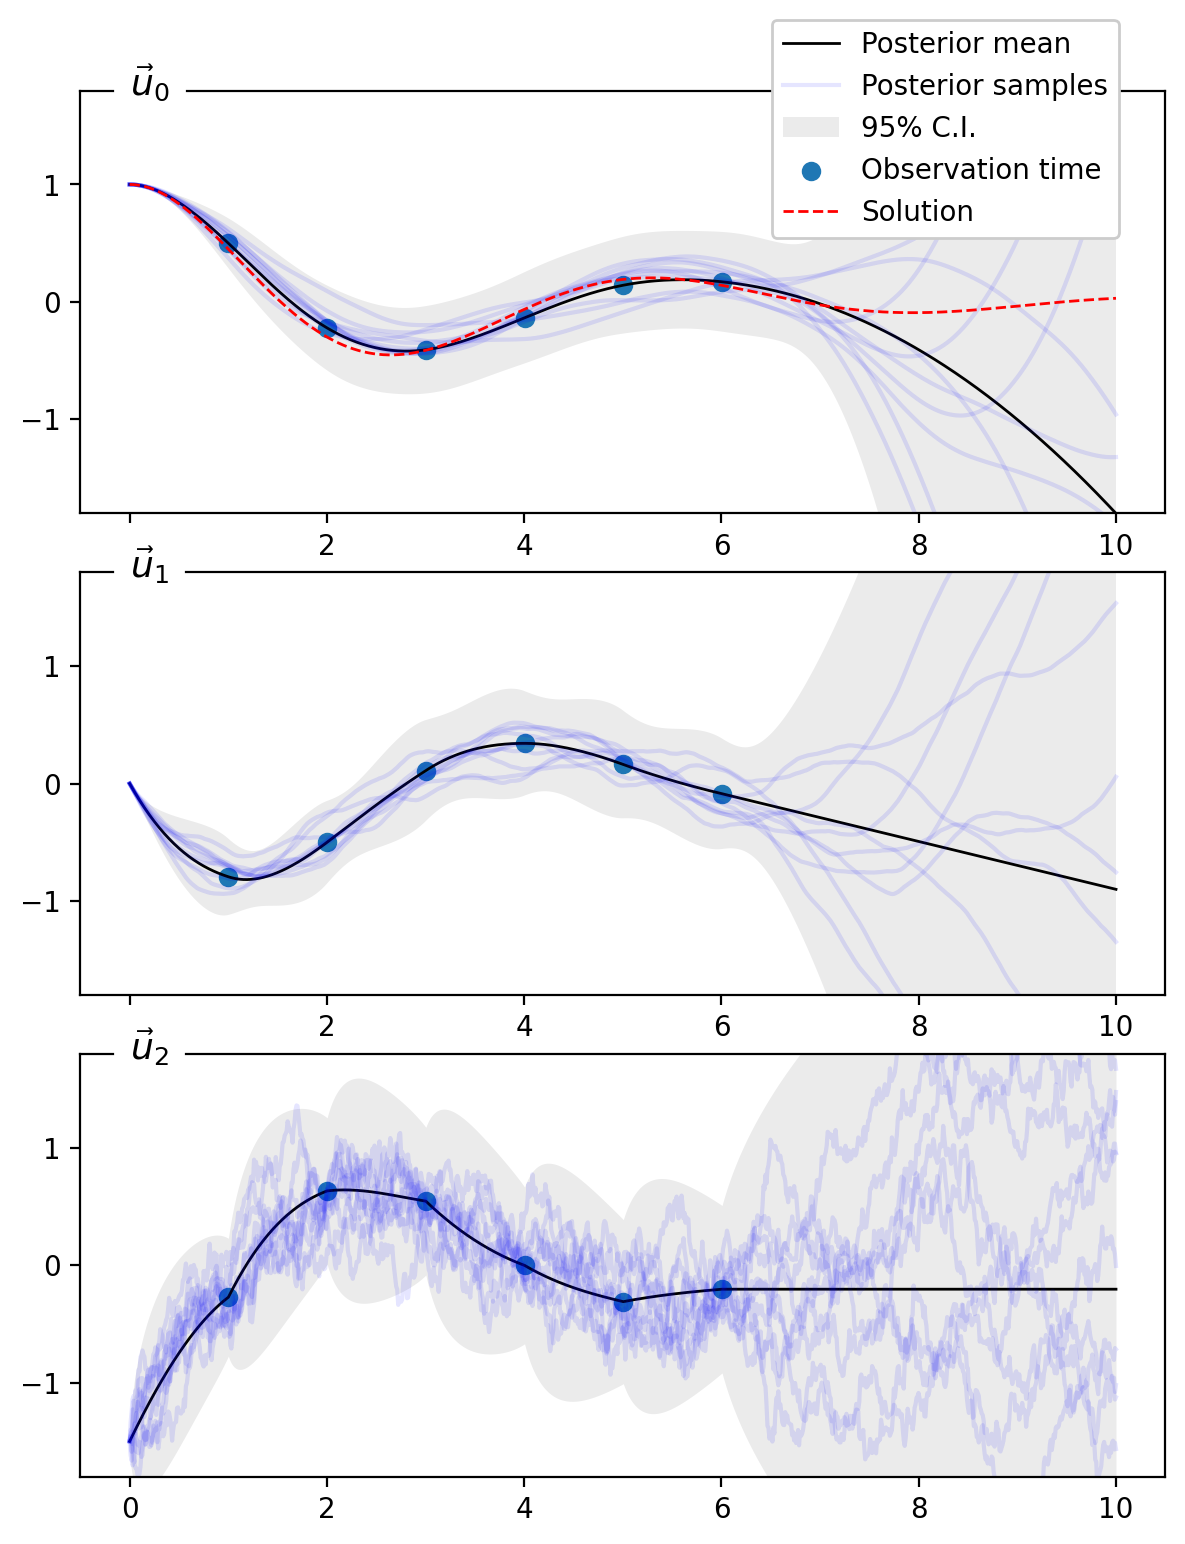

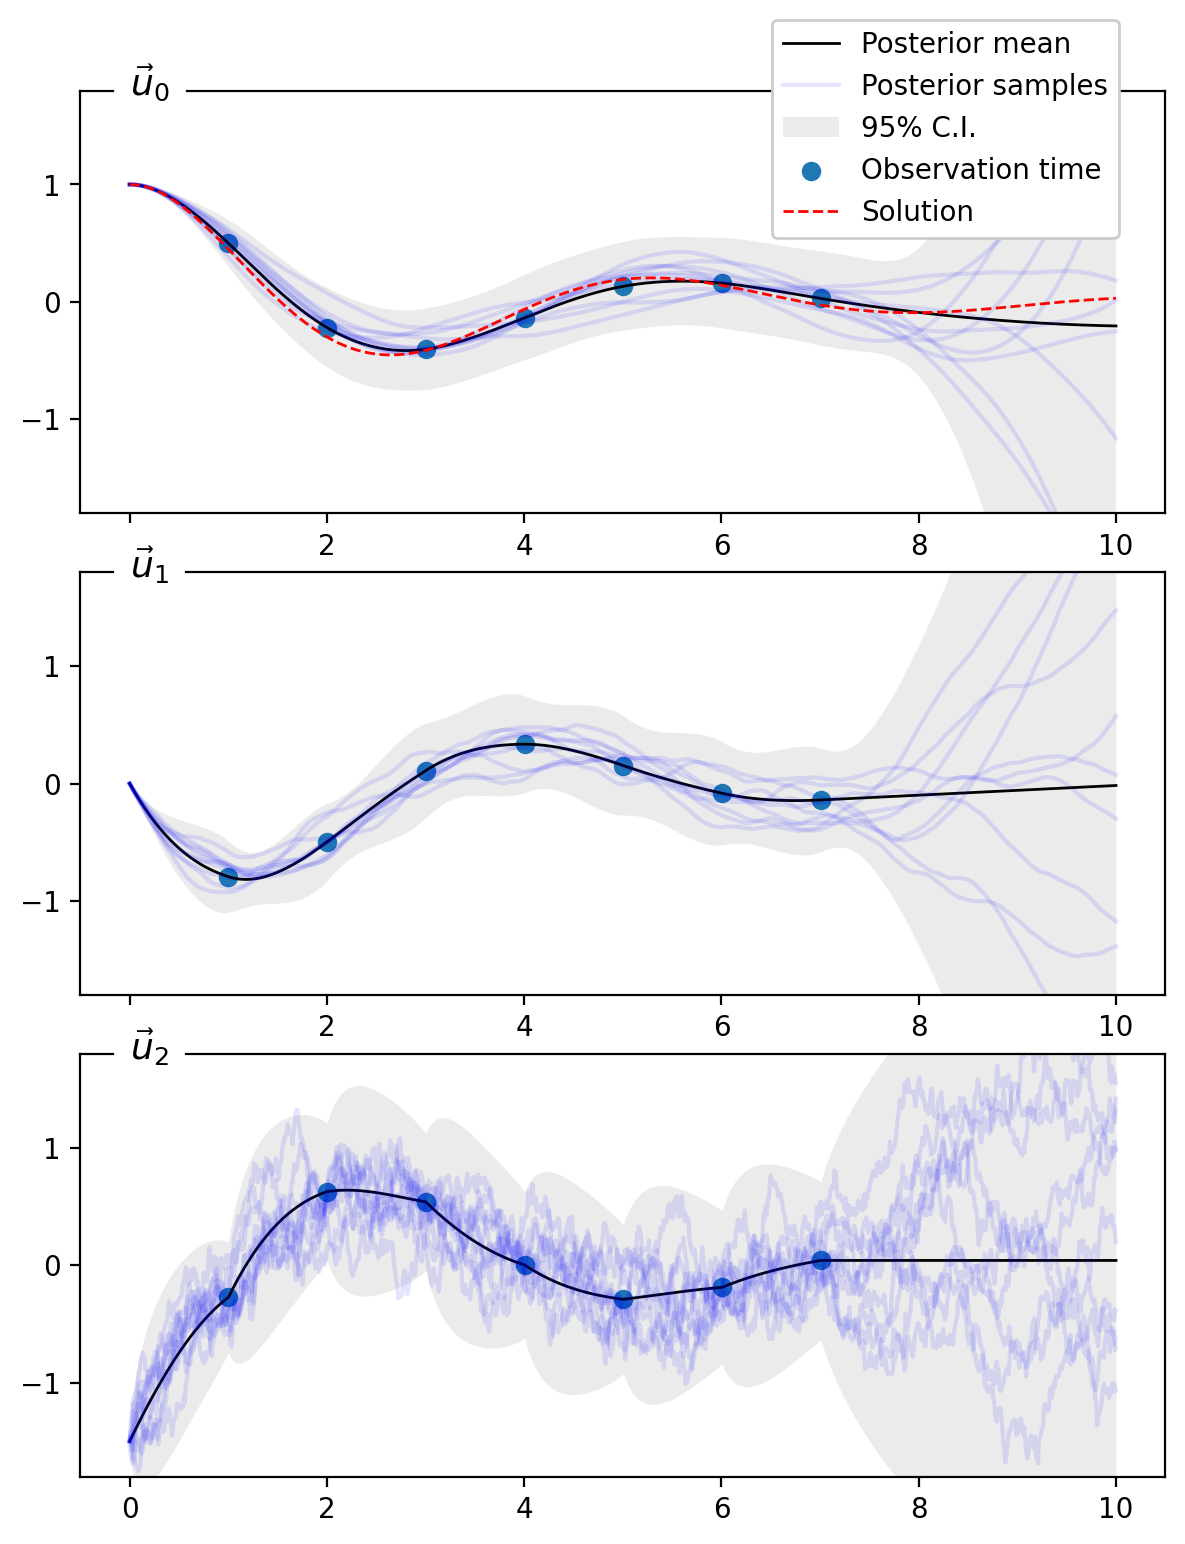

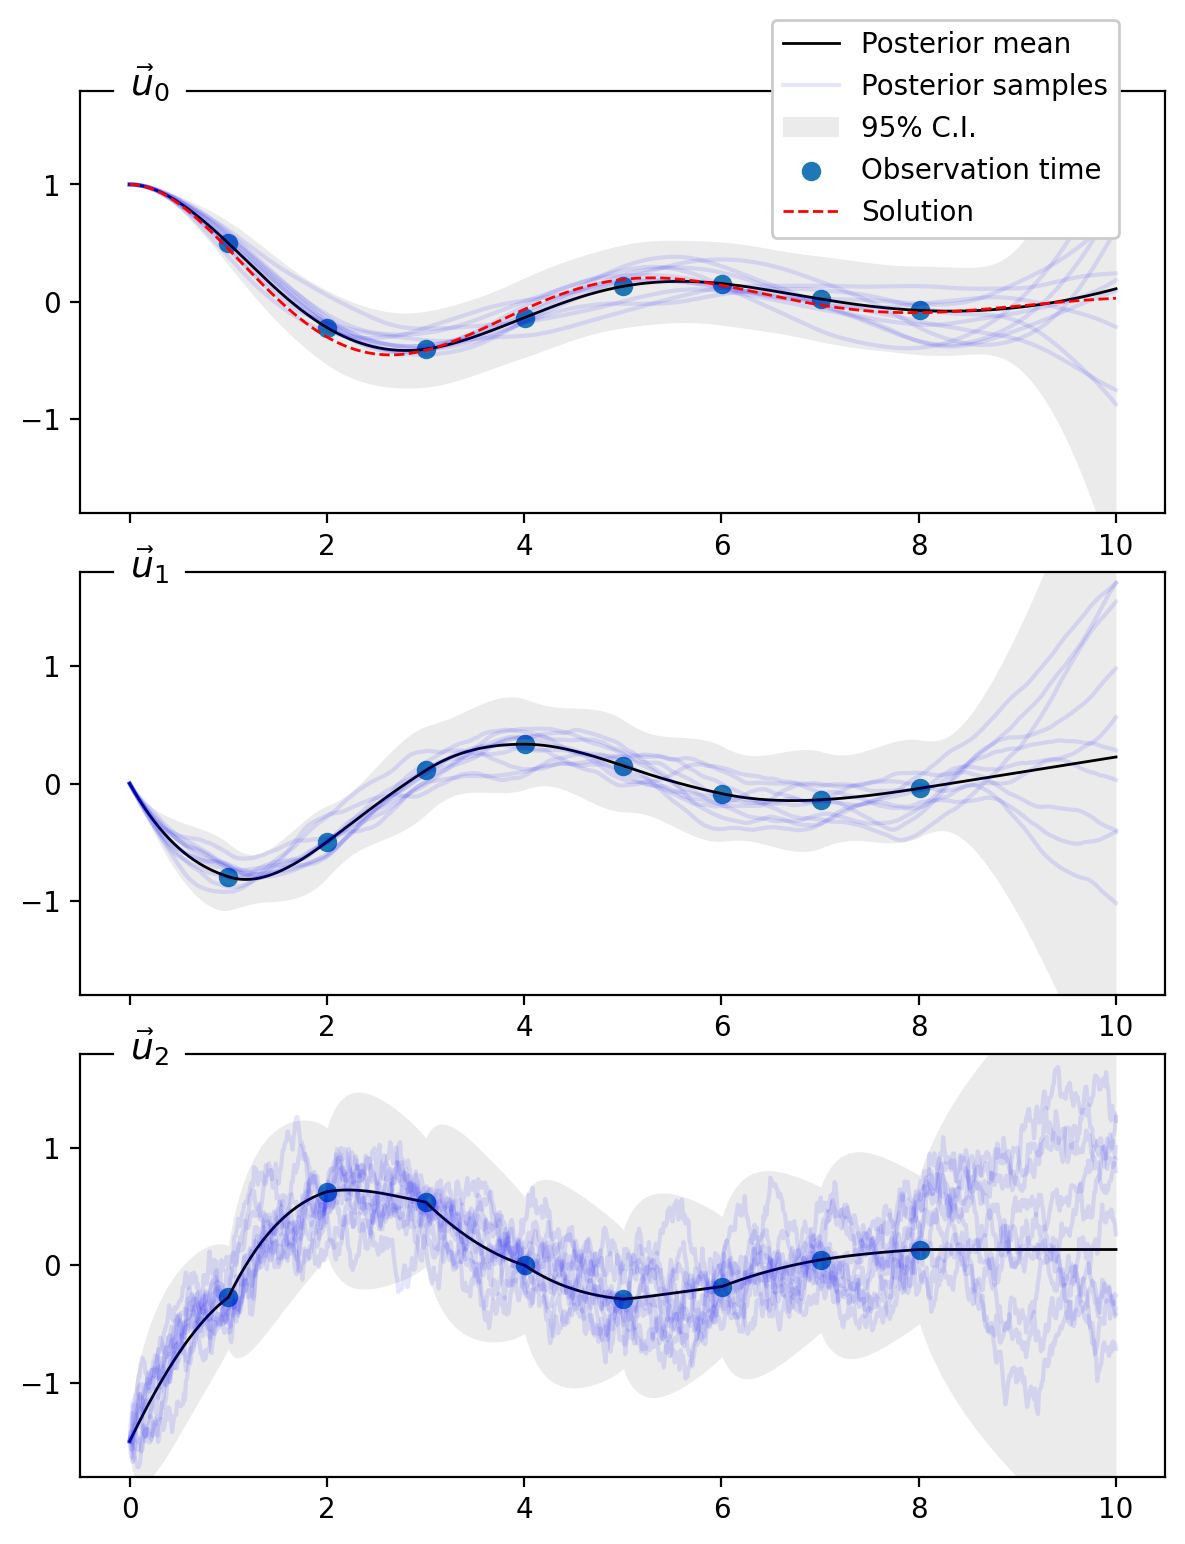

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000
end_time = 10
times = jnp.linspace(0, end_time, timesteps, endpoint=True)
# y_positions = jnp.array([0.0, 1.0, 0.0, 1.0, 0])[:timesteps]

from probabilistic_numerics import kalman_filter as pn
import imageio

max_obs = 10


def fit_trajectory_samples(q, n_observations, axs, mode: str):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    k = 1.5
    d = 0.6
    initial_mean = initial_mean.at[0].set(1)
    initial_mean = initial_mean.at[2].set(-k)
    delta = end_time / (timesteps - 1)

    def obs(state, time, step):
        return state[2:3] + k * state[0:1] + d * state[1:2]

    if mode == "incremental":
        updates = jnp.zeros((timesteps)).astype(bool)
        for j in range(1, n_observations):
            updates = updates.at[j * (timesteps // max_obs)].set(1)
    elif mode == "fill":
        updates = jnp.zeros((timesteps)).astype(bool)
        updates = updates.at[:: (timesteps // n_observations)].set(1)
        updates = updates.at[0].set(0)

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=0 * jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0] + [0.0] * q),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="IWP",
        observation_function=obs,
        update_indicator=updates,
        observation_uncertainty=jnp.eye(state) * 0.000,
        n_samples=[10, 15, 10, 10, 10][q],
    )
    names = [r"$\vec{u}_0$", r"$\vec{u}_1$", r"$\vec{u}_2$"]
    for q, (ax, name) in enumerate(zip(axs.flatten(), names)):
        ax.plot(times, means[:, q], label="Posterior mean", color="k", linewidth=1)
        for i in range(1, jnp.size(samples_, axis=1)):
            ax.plot(
                times,
                samples_[:, i, q],
                color="blue",
                alpha=0.1,
            )
        ax.plot(
            times,
            samples_[:, 0, q],
            label="Posterior samples",
            color="blue",
            alpha=0.1,
        )
        ax.fill_between(
            times,
            -2.96 * stds[:, q] + means[:, q],
            2.96 * stds[:, q] + means[:, q],
            label="95% C.I.",
            color="k",
            linewidth=0,
            alpha=0.08,
        )
        ax.scatter(
            times[updates],
            means[:, q][updates],
            label="Observation time",
        )

        # ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-1.8, 1.8)

        # ax.set_axis_off()
        ax.text(0.0, 1.75, f"{name}", backgroundcolor="white", fontsize=13)

    # plotting true damped harmonic oscillator solution

    # axs[0].plot(
    #     times,
    #     (jnp.cos(times * jnp.sqrt(k - (d**2) / 4))) * jnp.exp(-times * (d / 2)),
    #     label="Solution",
    #     color="r",
    #     linestyle="--",
    #     linewidth=1,
    # )

    return means


fig, axs = plt.subplots(2, 1, figsize=(7, 3 * (5 + 1)), dpi=200)
# less horizontal space
fig.subplots_adjust(hspace=0.14)


solution = fit_trajectory_samples(4, 100, axs, "fill")

plt.close(fig)


images = []
for i in range(1, max_obs):
    fig, axs = plt.subplots(3, 1, figsize=(7, 3 * 3), dpi=200)
    # less horizontal space
    fig.subplots_adjust(hspace=0.14)
    fit_trajectory_samples(2, n_observations=i, axs=axs, mode="incremental")

    axs[0].plot(
        times,
        solution[:, 0],
        label="Solution",
        color="r",
        linestyle="--",
        linewidth=1,
    )
    # legend above first plot
    axs[0].legend(
        fancybox=True,
        framealpha=1,
        fontsize=10,
        loc="upper right",
        bbox_to_anchor=(0.97, 1.2),
    )

    # Save the figure as an image
    image_path = f"../markdown/presentation/solving_damped_spring_{i}_points.png"
    fig.savefig(
        image_path,
        dpi=300,
        transparent=False,
        bbox_inches="tight",
        pad_inches=0,
    )
    images.append(imageio.imread(image_path))

for i in range(max_obs, 3 * max_obs, 2):
    fig, axs = plt.subplots(3, 1, figsize=(7, 3 * 3), dpi=200)
    # less horizontal space
    fig.subplots_adjust(hspace=0.14)
    fit_trajectory_samples(2, n_observations=i, axs=axs, mode="fill")

    axs[0].plot(
        times,
        solution[:, 0],
        label="Solution",
        color="r",
        linestyle="--",
        linewidth=1,
    )
    # legend above first plot
    axs[0].legend(
        fancybox=True,
        framealpha=1,
        fontsize=10,
        loc="upper right",
        bbox_to_anchor=(0.97, 1.2),
    )

    # Save the figure as an image
    image_path = f"../markdown/presentation/solving_damped_spring_{i}_points.png"
    fig.savefig(
        image_path,
        dpi=300,
        transparent=False,
        bbox_inches="tight",
        pad_inches=0,
    )
    images.append(imageio.imread(image_path))
    # close the figure
    plt.close(fig)


In [2]:
# Save the images as a GIF, repeating
gif_path = "../markdown/presentation/solving_damped_spring.gif"
# each image should be shown for 1 second
imageio.mimsave(gif_path, images + list(reversed(images)), fps=5, loop=0)

# State Tracking

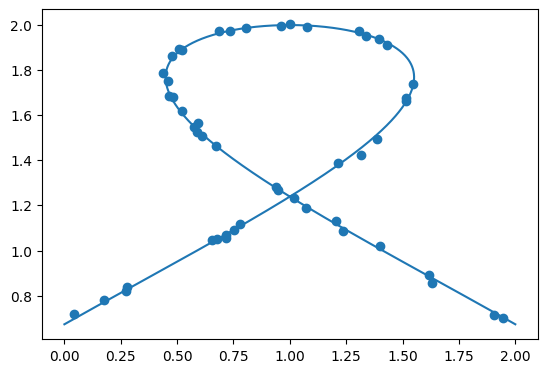

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 1000

times = jnp.linspace(0, 1, timesteps)
x_positions = jnp.sin(times * 2 * jnp.pi) + 2 * times
y_positions = jnp.exp(-((0.5 + -times) ** 2)) * 6 - 4

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(x_positions, y_positions, label="True trajectory")
noisy_samples = (
    jnp.stack([x_positions, y_positions], axis=1)
    + jax.random.normal(jax.random.PRNGKey(0), (timesteps, 2)) * 0.01
)

n_samples = 50
samples_idx = jax.random.permutation(jax.random.PRNGKey(2), jnp.arange(timesteps))[
    :n_samples
]

ax.scatter(
    noisy_samples[samples_idx][:, 0],
    noisy_samples[samples_idx][:, 1],
    label="Subsampled observations",
)
# convert to mask

mask = jnp.zeros(timesteps).astype(bool)
mask = mask.at[samples_idx].set(True)
mask = mask.at[0].set(False)
mask = mask.at[-1].set(True)

Running q = 0
SDE_coef
[[0. 0.]
 [0. 0.]]
Running q = 1
SDE_coef
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Running q = 2
SDE_coef
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


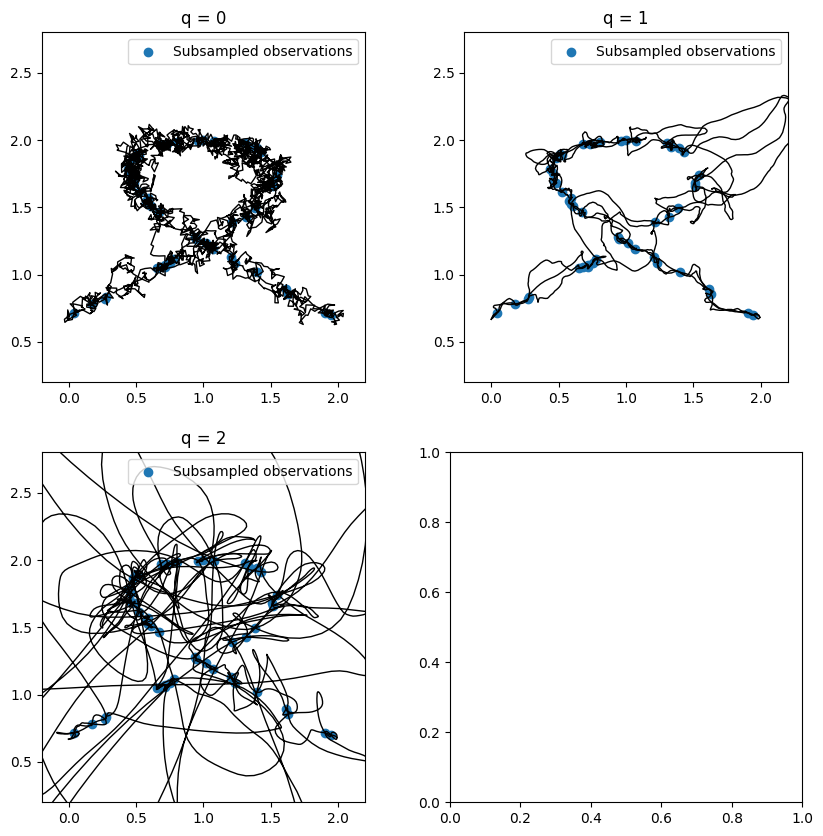

In [7]:
from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 2
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[:2].set(noisy_samples[0])
    delta = 1 / (timesteps - 1)

    def obs(state, time, step):
        sample = noisy_samples[step]
        return state[:2] - sample

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-jnp.eye(state) * 10,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0.0] * state + [1.0] * (state * q)),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="iwp",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0,
        n_samples=3,
    )
    for i in range(jnp.size(samples_, axis=1)):
        ax.plot(
            samples_[:, i, 0],
            samples_[:, i, 1],
            # label="Inferred trajectory",
            color="k",
            linewidth=1,
        )
    ax.scatter(
        noisy_samples[samples_idx][:, 0],
        noisy_samples[samples_idx][:, 1],
        label="Subsampled observations",
    )
    ax.set_aspect("equal")
    # ax.plot(
    #     means[:, 0],
    #     means[:, 1],
    #     label="Inferred trajectory",
    #     color="r",
    #     linewidth=0.4,
    # )

    ax.set_xlim(-0.2, 2.2)
    ax.set_ylim(0.2, 2.8)
    ax.legend()


qs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9][:3]
width = int(jnp.ceil(jnp.sqrt(len(qs))))
height = int(jnp.ceil(len(qs) / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 5 * height))
for q, ax in zip(qs, ax.flatten()):
    print(f"Running q = {q}")
    ax.set_title(f"q = {q}")
    fit_trajectory_samples(q, ax)

Running q = 2, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
Running q = 3, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
Running q = 4, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]
Running q = 5, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]
Running q = 6, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]]
Running q = 8, prior = iwp, evals = 50
SDE_coef
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 

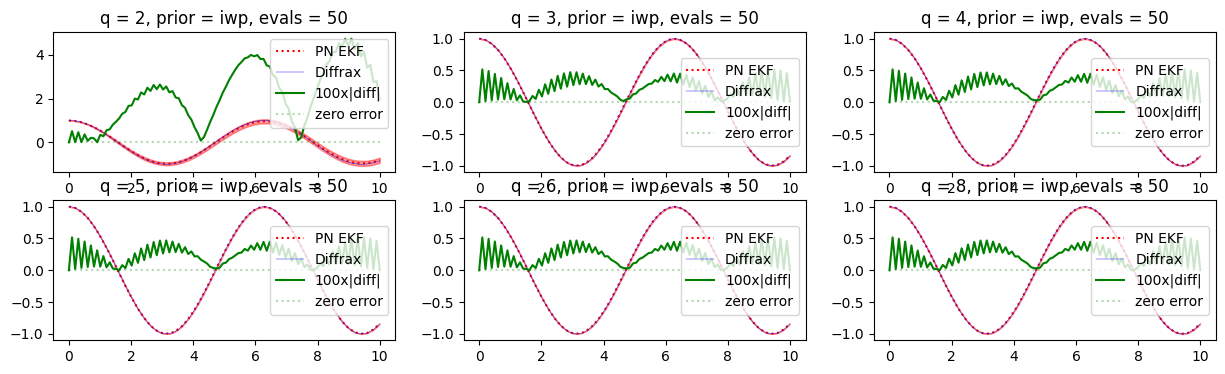

In [9]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x])


end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, 100, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0.0, 0.0, 0.0] * state + [1.0] * (state * (q - 2))),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        observation_uncertainty=jnp.eye(1) * 0,
        n_samples=0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis,
        jnp.linspace(0, end_time, n_solution_points, endpoint=True),
        means[:, 0],
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r",
    )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    ax.plot(x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|diff|", color="g")
    ax.plot(
        x_axis, 100 * [0], label="zero error", color="g", linestyle="dotted", alpha=0.3
    )

    ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


qs = [
    2,
    3,
    4,
    5,
    6,
    8,
]
priors = [
    ("iwp", jnp.zeros((1, 1))),
    # ("wave", -jnp.eye(1)),
]
evaluation_counts = jnp.linspace(50, 1000, 3)[:1]
import itertools

amount = len(qs) * len(priors) * len(evaluation_counts)
width = int(jnp.ceil(jnp.sqrt(amount)))
height = int(jnp.ceil(amount / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 2 * height))

results = []

for (q, (prior_name, prior_matrix), timesteps), ax in zip(
    itertools.product(qs, priors, evaluation_counts), ax.flatten()
):
    print(f"Running q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    ax.set_title(f"q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    means, stds = pn_solve_nonlinear_IVP(
        q, ax, int(timesteps), prior_name, prior_matrix
    )
    results += [(q, prior_name, int(timesteps), means, stds)]

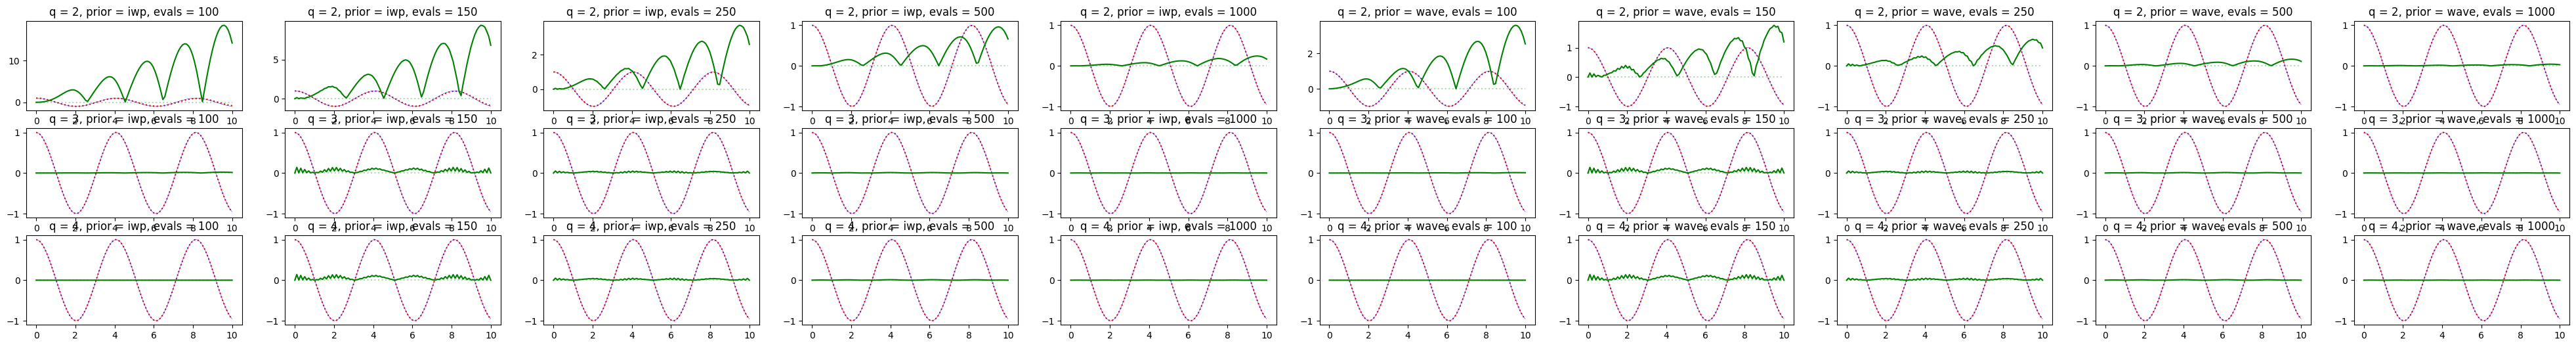

In [5]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def tan(x):
    return jnp.sin(x) / jnp.cos(x)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x + -tan(x)])


end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, 100, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]

import probdiffeq.taylor as taylor
import jax
import jax.numpy as jnp


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    assert 2 * (n_solution_points // 2) == n_solution_points
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)

    tcoeffs = taylor.odejet_padded_scan(
        lambda y, dy: -y - tan(y), (initial_mean[0], initial_mean[1]), num=q - 1
    )
    initial_mean = jnp.array(tcoeffs).flatten()

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([+state[0] + tan(state[0]) + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.zeros_like(initial_mean),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        observation_uncertainty=jnp.zeros(1),
        n_samples=0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis,
        jnp.linspace(0, end_time, n_solution_points, endpoint=True),
        means[:, 0],
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    # ax.fill_between(
    #     x_axis,
    #     means - stds * 3,
    #     means + stds * 3,
    #     alpha=0.4,
    #     color="r",
    # )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    ax.plot(x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|diff|", color="g")
    ax.plot(
        x_axis, 100 * [0], label="zero error", color="g", linestyle="dotted", alpha=0.3
    )

    # ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


qs = [
    2,
    3,
    4,
    5,
    6,
    8,
][:3]
priors = [
    ("iwp", jnp.zeros((1, 1))),
    ("wave", -2 * jnp.eye(1)),
]
evaluation_counts = [100, 150, 250, 500, 1000]
import itertools

amount = len(qs) * len(priors) * len(evaluation_counts)
height = len(qs)
width = int(jnp.ceil(amount / height))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 2 * height))

results = []

for (q, (prior_name, prior_matrix), timesteps), ax in zip(
    itertools.product(qs, priors, evaluation_counts), ax.flatten().T
):
    # print(f"Running q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    ax.set_title(f"q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    means, stds = pn_solve_nonlinear_IVP(
        q, ax, int(timesteps), prior_name, prior_matrix
    )
    results += [(q, prior_name, int(timesteps), means, stds)]

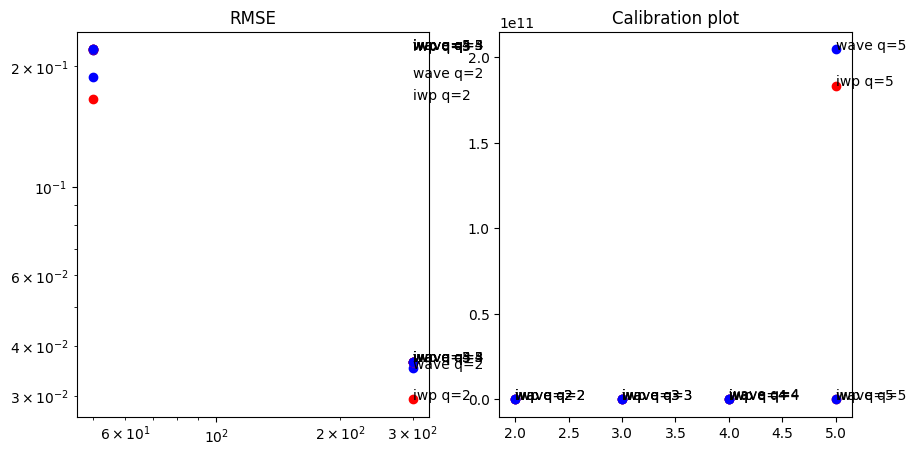

In [10]:
fig, (rmseplot, calibration_plot) = plt.subplots(1, 2, figsize=(10, 5))
rmseplot.set_title("RMSE")
rmseplot.loglog()
calibration_plot.set_title("Calibration plot")

for q, prior_name, n_solution_points, means, stds in results:
    rmse = jnp.sqrt(jnp.mean((means[1:] - diffrax_sol[1:]) ** 2))
    rmseplot.plot(
        n_solution_points,
        rmse,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    rmseplot.text(timesteps, rmse, f"{prior_name} q={q}")

    calibration = jnp.mean(((means[1:] - diffrax_sol[1:]) / stds[1:]) ** 2) / 99
    calibration_plot.plot(
        q,
        calibration,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    calibration_plot.text(q, calibration, f"{prior_name} q={q}")

SDE_coef
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


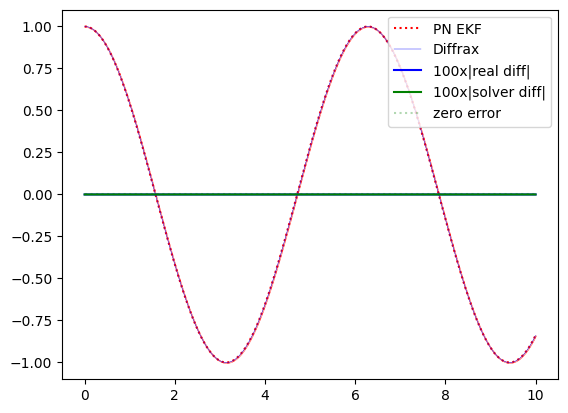

In [18]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x])


timesteps = 1000

end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, timesteps, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]

real_sol = jnp.cos(jnp.linspace(0, end_time, timesteps))


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0.0, 0.0, 0.0] * state + [1.0] * (state * (q - 2))),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        observation_uncertainty=jnp.eye(1) * 0,
        n_samples=0,
    )

    x_axis = jnp.linspace(0, end_time, timesteps)
    means = jnp.interp(
        x_axis,
        jnp.linspace(0, end_time, n_solution_points, endpoint=True),
        means[:, 0],
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r",
    )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    ax.plot(
        x_axis,
        100 * jnp.abs(real_sol - diffrax_sol),
        label="100x|real diff|",
        color="b",
    )
    ax.plot(
        x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|solver diff|", color="g"
    )
    ax.plot(
        x_axis,
        timesteps * [0],
        label="zero error",
        color="g",
        linestyle="dotted",
        alpha=0.3,
    )

    ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


fig, ax = plt.subplots(1, 1)

means, stds = pn_solve_nonlinear_IVP(q, ax, int(timesteps), prior_name, prior_matrix)